# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



## Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](https://core.ac.uk/outputs/55616194) for more information on the data and features.



## Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

> The classification goal is to predict if a client will subscribe a term deposit.

> The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For the whole database considered, there were 6499 successes (8% success rate).

## Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
pd.options.display.max_columns = None  # display all dataframe columns in the notebook
import numpy as np
import math
from scipy import stats
import time  # compute execution time

# models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz

# impute missing values
# explicitly require the experimental feature for the IterativeImputer
from sklearn.experimental import enable_iterative_imputer
# now we can import the IterativeImputer normally
from sklearn.impute import IterativeImputer, SimpleImputer

# transformers
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from embedding_encoder import EmbeddingEncoder

# Bayesian optimization over hyperparameters
from skopt.searchcv import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

# metrics
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# visualize trees
from IPython.display import Image  
from six import StringIO
import pydotplus, graphviz

# permutation importance
from sklearn.inspection import permutation_importance

# pipeline
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline 

# display pipelines
from sklearn import set_config
set_config(display="diagram")

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)  # set standard figure size
%matplotlib inline

# suppress warnings
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# function that checks the percentage of outliers based on the z-score

def detect_outliers_zscore(data, col):
    zscore = np.abs(stats.zscore(data[col]))
    outlier_list = np.where(zscore>4.5,True,False)
    
    return 100.*outlier_list.sum()/data.shape[0]

In [3]:
# function that measures multicollinearity

def sklearn_vif(exogs, data):
    
    # initialize the dictionary
    vif_dict = {}
    
    # for the input data
    for exog in exogs:
        not_exog = [i for i in exogs if i!=exog]
        X, y = data[not_exog], data[exog]

        # compute R2
        r_squared = LinearRegression().fit(X,y).score(X,y)
        
        # compute VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif
    
    # return the VIF dataframe
    df_vif = pd.DataFrame({'VIF': vif_dict})
    
    return df_vif

In [4]:
# read data
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [5]:
# data size
df.shape

(41188, 21)

Our data has 41,188 rows and 21 columns.

In [6]:
# look at the first few rows
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

In [7]:
# data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Problem 3: Understanding the Features

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:

# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



The following categorical features have missing values:
- `job`
- `marital`
- `education`
- `default` (A default occurs when a borrower stops making the required payments on a debt. [[Source](https://www.investopedia.com/terms/d/default2.asp)])
- `housing`
- `loan`

Those missing values are all labeled as `unknown`.

Features don't need to be coerced to a different data type.

## Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

As stated in the **Abstract** of the paper:
> The business goal is to find a model that can explain success of a contact, i.e. if the client subscribes the deposit. Such model can increase campaign efficiency by identifying the main characteristics that affect success, helping in a better management of the available resources (e.g. human effort, phone calls, time) and selection of a high quality and affordable set of potential buying customers.

## Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [8]:
# create a new dataframe df_clean, which will be the cleaned version of the original dataframe df
df_clean = df.copy()

# using just the bank information features
df_clean = df_clean[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']]

In [9]:
# set target column
target_col = 'y'

In [10]:
df_clean.head()

age        job  marital    education  default housing loan   y
0   56  housemaid  married     basic.4y       no      no   no  no
1   57   services  married  high.school  unknown      no   no  no
2   37   services  married  high.school       no     yes   no  no
3   40     admin.  married     basic.6y       no      no   no  no
4   56   services  married  high.school       no      no  yes  no

I will apply encoding and transformations of the features as part of the pipeline, which I will define in Problem 8 below.

### Explore Numeric Column

We have one numeric column: `age`.

In [11]:
num_cols = ['age']

In [12]:
# descriptive statistics
df_clean.describe()

age
count  41188.00000
mean      40.02406
std       10.42125
min       17.00000
25%       32.00000
50%       38.00000
75%       47.00000
max       98.00000

`age` is right-skewed, since its mean value is larger than its median value (50th percentile).

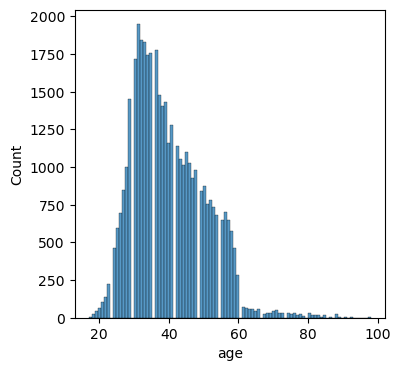

In [13]:
# distribution plot
plt.figure(figsize=(4,4))
sns.histplot(df_clean['age']);

We get a visual view of the outliers to the right, which we address next.

### Handle Outliers

In [14]:
# calculate percentage of outliers using the detect_outliers_zscore() function
outlier_zscore_dic = {}
for col in num_cols:
    outlier_val = detect_outliers_zscore(df_clean.dropna(subset=col), col)
    if outlier_val > 0:
        outlier_zscore_dic[col] = outlier_val

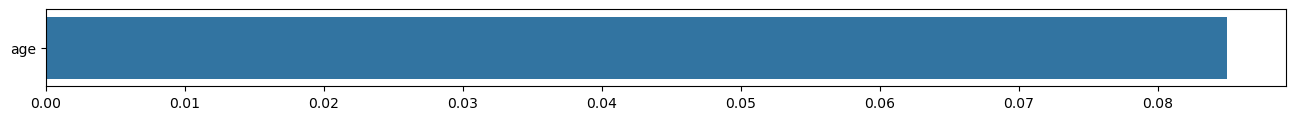

In [15]:
# sort the columns by their percentage of outliers
outlier_zscore_dic_sorted = {}
sorted_keys = sorted(outlier_zscore_dic, key=outlier_zscore_dic.get, reverse=True)

for w in sorted_keys:
    outlier_zscore_dic_sorted[w] = outlier_zscore_dic[w]
    
# plot percentage of outliers
plt.figure(figsize=(16, 1))
sns.barplot(x=list(outlier_zscore_dic_sorted.values()), y=list(outlier_zscore_dic_sorted.keys()));

In [16]:
# drop outliers
for col, _ in outlier_zscore_dic.items():
    zscore = np.abs(stats.zscore(df_clean[col]))
    
    size_before = df_clean.shape[0]
    df_clean.drop(df_clean[np.abs(stats.zscore(df_clean[col]))>4.5].index, inplace=True)
    size_after = df_clean.shape[0]
    
    print('Cleaned {:.2f}% percentage of {}.'.format((size_before-size_after)*100./size_before, col))

Cleaned 0.08% percentage of age.


In [17]:
# new shape of the dataframe
df_clean.shape

(41153, 8)

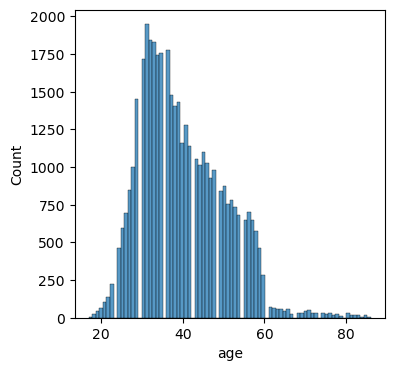

In [18]:
# distribution plot
plt.figure(figsize=(4,4))
sns.histplot(df_clean['age']);

### Explore Categorical Columns

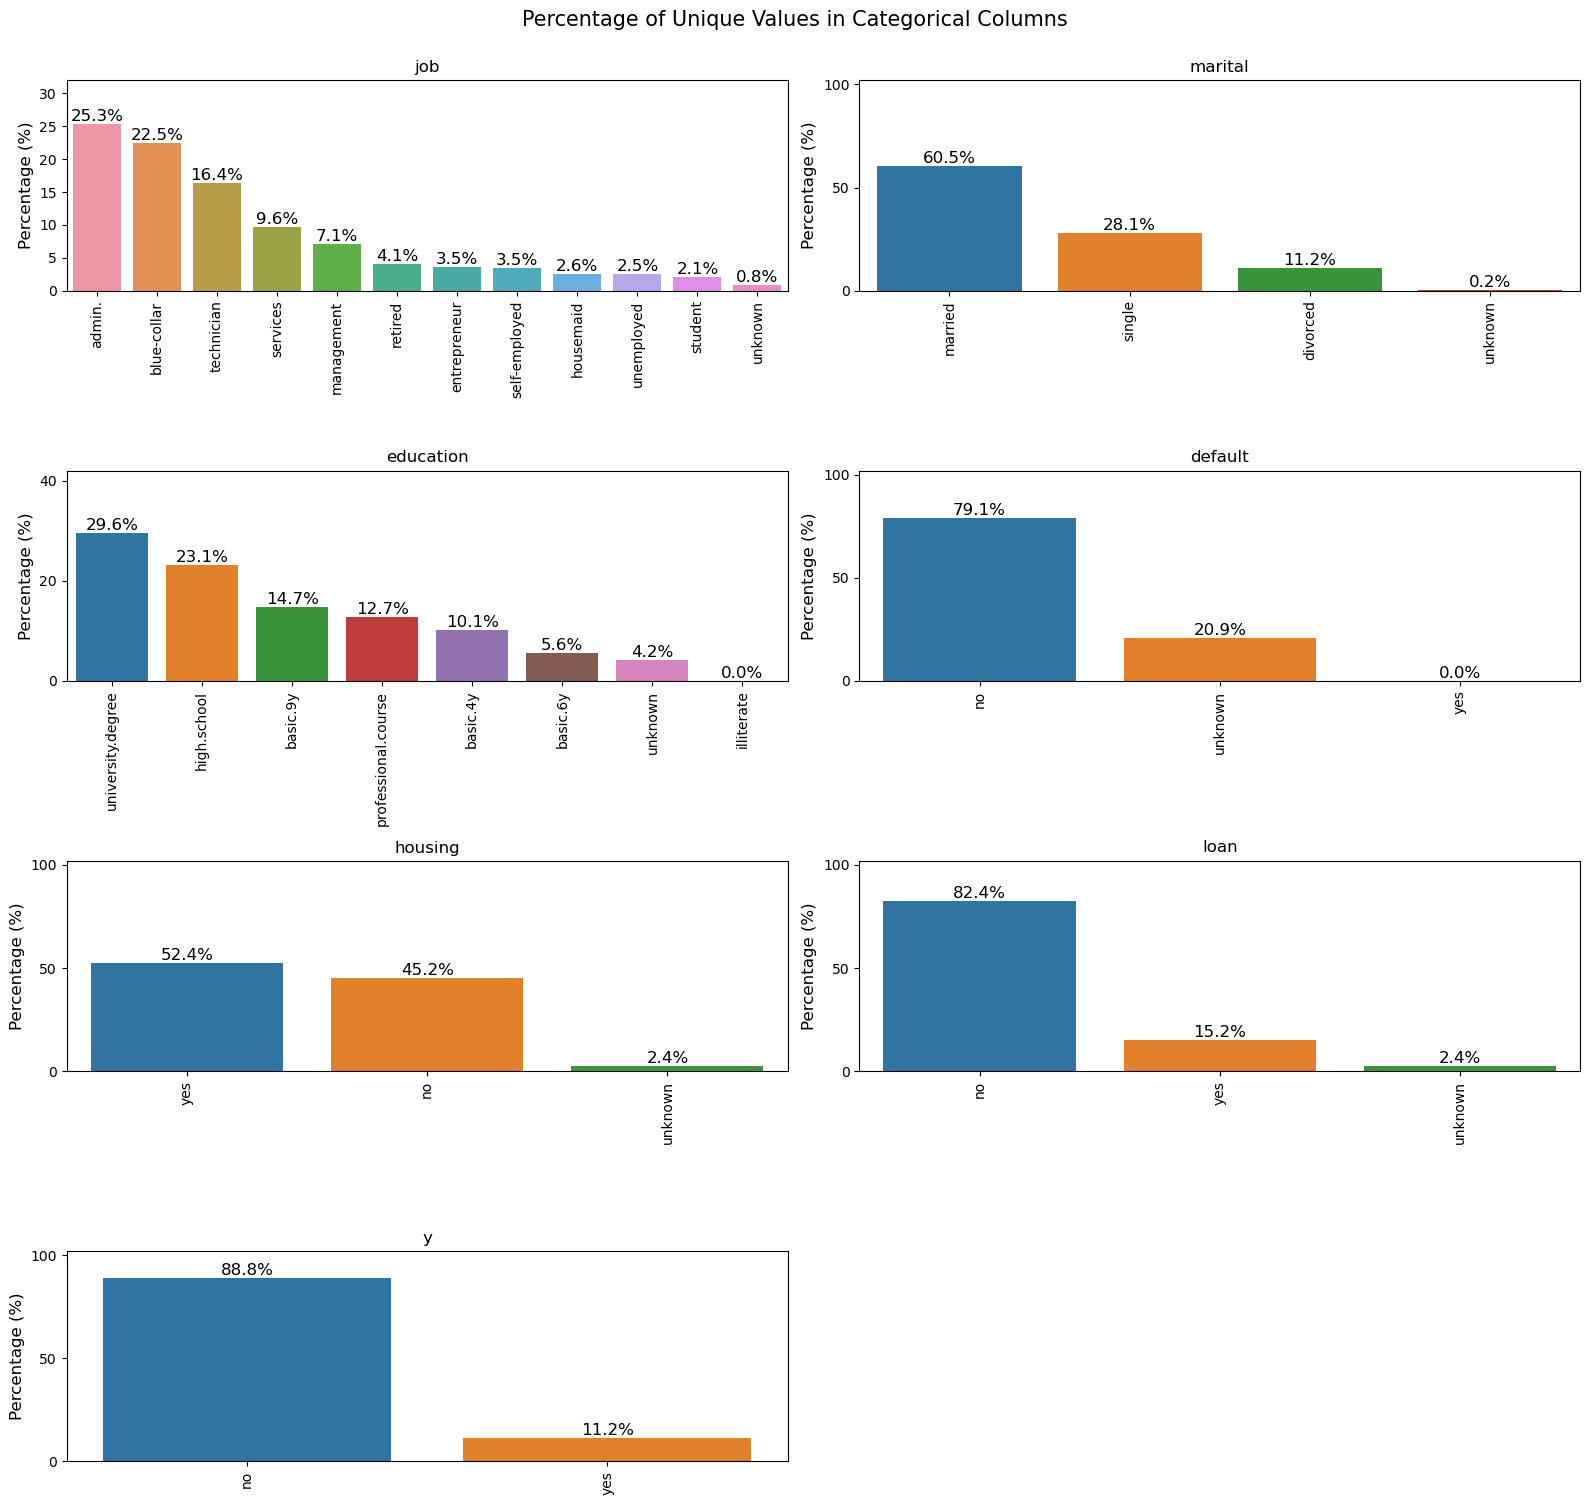

In [19]:
# Calculate and plot (bar plot) the percentage of unique values in categorical columns.

i=0
n_cols = 2
obj_cols = df_clean.select_dtypes(include='object').columns

fig, ax = plt.subplots(math.ceil((len(obj_cols)/n_cols)), n_cols, figsize=(16,15))
fig.suptitle('Percentage of Unique Values in Categorical Columns', fontsize=15, y=1.)

for col in obj_cols:
    df_col = df_clean[col].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()
 
    g = sns.barplot(x='index', y='Percentage (%)', data=df_col, ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    ax[i//n_cols,i%n_cols].set_xticklabels(ax[i//n_cols,i%n_cols].get_xticklabels(), rotation = 90)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(col, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    
    # add percentages as text to the bars
    for container in g.containers:
        g.bar_label(container, fmt='%.1f%%', fontsize=12)
    bottom, upper = g.get_ylim()
    g.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=5)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(obj_cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

- Our target variable is highly inbalanced.
- The data has imbalanced categorical features.
- We decide to remove the `iliterate`-category in the `education`-feature and the `yes`-category in the `default`-feature due to their low representation (about 0%):

In [20]:
# remove low-representative categories
df_clean = df_clean[~(df_clean['education'].isin(['illiterate']))]
df_clean = df_clean[~(df_clean['default'].isin(['yes']))]

Missing values (labeled as `unknown`):
 - The `default` feature has 20.9% missing values. The remaining values are all labeled as `no`. We decide to treat the `unknown`-category as a possible class label and keep it.
 - The remaining features have less than 4.3% missing values each, and we will impute them as part of the pipeline in Problem 8 below.

In [21]:
# replace 'unknown' with NaN (except for the 'default' feature)
for col in list(df_clean.drop(columns='default').select_dtypes(include='object').columns):
    df_clean[col] = np.where(df_clean[col]=='unknown', np.nan, df_clean[col]) 

We will encode the target variable to integers here and label the `yes`-class as the positive class.

In [22]:
# transform target column to integers
df_clean[target_col] = df_clean[target_col].replace({'yes':1, 'no':0})

### Analyse Target

#### Univariate Analyis

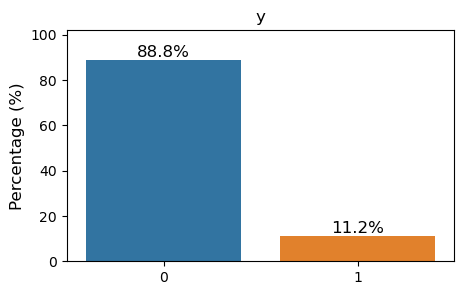

In [23]:
# Calculate and plot (bar plot) the percentage of unique values in the target column.

df_col = df_clean[target_col].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()

plt.figure(figsize=(5,3))
g = sns.barplot(x='index', y='Percentage (%)', data=df_col)

g.set_xticks(g.get_xticks(), fontsize = 12)
g.set_yticks(g.get_yticks(), fontsize = 12)
g.set_title(target_col, fontsize=12)
g.set_xlabel('')
g.set_ylabel('Percentage (%)', fontsize = 12)
    
# add percentages as text to the bars
for container in g.containers:
    g.bar_label(container, fmt='%.1f%%', fontsize=12)
bottom, upper = g.get_ylim()
g.set_ylim(bottom, upper+2)
plt.subplots_adjust(hspace=5)

#### Bivariate Analyis

##### Numerical Value Relationship

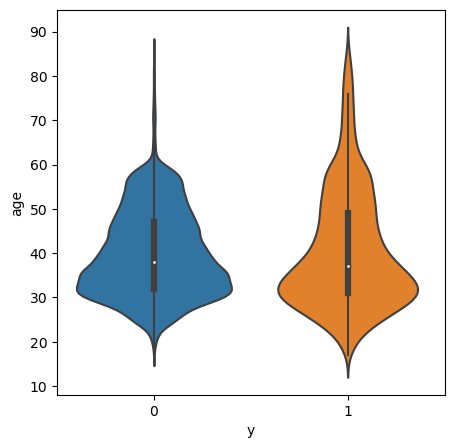

In [24]:
# violin plot between the target and the numercal variable
plt.figure(figsize=(5,5))
sns.violinplot(y='age',x=target_col, data=df_clean);

##### Categorical Value Relationship

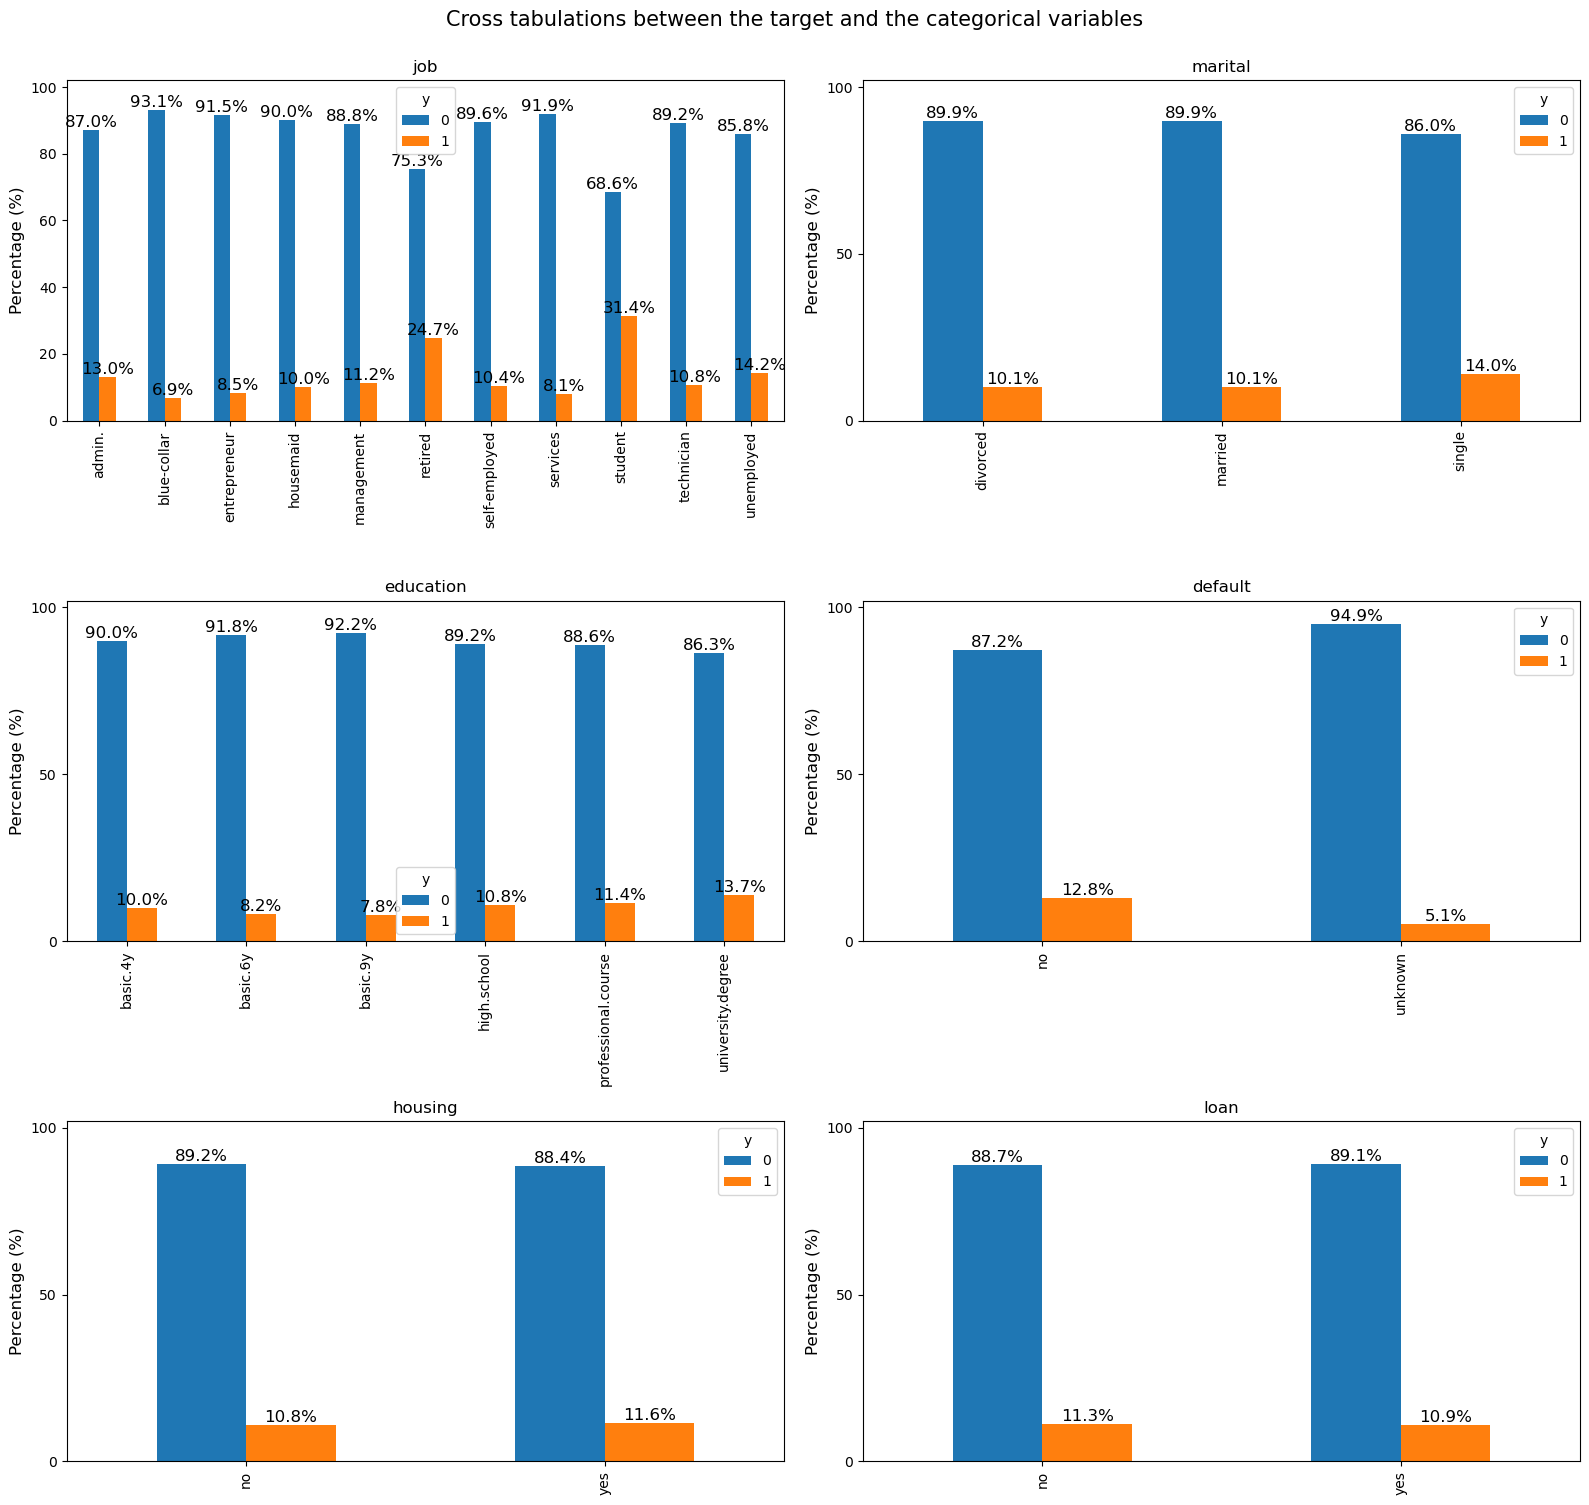

In [25]:
# cross tabulations between the target and the categorical variables

i=0
n_cols = 2

obj_cols = df_clean.select_dtypes(include='object').columns

fig, ax = plt.subplots(math.ceil((len(obj_cols)/n_cols)), n_cols, figsize=(16,15))
fig.suptitle('Cross tabulations between the target and the categorical variables', fontsize=15, y=1.)

for col in obj_cols:
    
    # Creating crosstab
    crosstb = 100. * pd.crosstab(df_clean[col], df_clean[target_col], normalize='index')

    # Creating barplot
    g = crosstb.plot.bar(rot=0, ax=ax[i//n_cols,i%n_cols])
      
    g.set_xticks(g.get_xticks(), fontsize = 12)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    ax[i//n_cols,i%n_cols].set_xticklabels(ax[i//n_cols,i%n_cols].get_xticklabels(), rotation = 90)
    g.set_title(col, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    
    # add percentages as text to the bars
    for container in g.containers:
        g.bar_label(container, fmt='%.1f%%', fontsize=12)
    bottom, upper = g.get_ylim()
    g.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=5)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(obj_cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

## Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline model is the model that always predicts the most occuring class, which is class 0 (client will not subscribe a term deposit). The accuracy of that baseline model is:

In [26]:
df_clean[target_col].value_counts(normalize = True)[0]

0.8877030049596422

## Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Train - Test - Split

In [27]:
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(30849, 7)
(10283, 7)
(30849,)
(10283,)


### Create Pipeline

In [28]:
## define variable types

# numeric variables
num_cols = list(X.select_dtypes(include='number').columns)

# nominal variables
nominal_cols = list(X.select_dtypes(include='object').columns)

In [31]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Target encoded and imputed via the IterativeImputer.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', TargetEncoder(handle_unknown='return_nan', handle_missing='return_nan')),
        ('imputer', IterativeImputer(initial_strategy='median', random_state=0))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

In [32]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('log_reg', LogisticRegression(random_state=4, n_jobs=-1))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(handle_missing='return_nan',
                                                                                 handle_unknown='return_nan')),
                                                                  ('imputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=0))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('log_reg', LogisticRegression(n_jobs=-1, random_state=4))])

## Problem 9: Score the Model

What is the accuracy of your model?

In [33]:
# predict
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

The train accuracy is:

In [34]:
accuracy_score(y_train, y_train_pred)

0.887711108950047

The test accuracy is:

In [35]:
accuracy_score(y_test, y_test_pred)

0.8876786929884275

which is lightly lower than the accuracy of the baseline model.

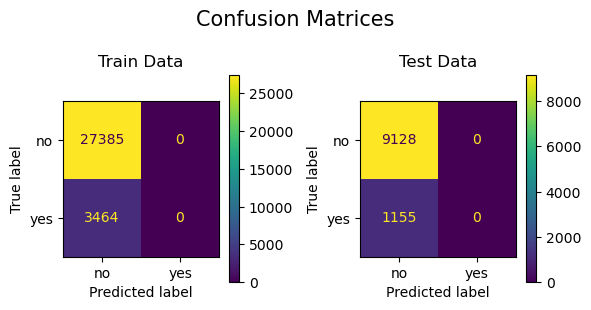

In [36]:
## confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, y_train_pred), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_test_pred), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [37]:
# classification report on train data
print(classification_report(y_train, y_train_pred, target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.89      1.00      0.94     27385
         yes       0.00      0.00      0.00      3464

    accuracy                           0.89     30849
   macro avg       0.44      0.50      0.47     30849
weighted avg       0.79      0.89      0.83     30849



In [38]:
# classification report on test data
print(classification_report(y_test, y_test_pred, target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.89      1.00      0.94      9128
         yes       0.00      0.00      0.00      1155

    accuracy                           0.89     10283
   macro avg       0.44      0.50      0.47     10283
weighted avg       0.79      0.89      0.83     10283



This shows that the accuracy score is not reliable for this dataset due to its imbalancy. Even though the accuracy score is relatively high, the recall score (for the `yes`-class) is 0. Our simple model can't predict the `yes`-class.

In [39]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].get_feature_names_out()) + \
                pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].cols

feature_names

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']

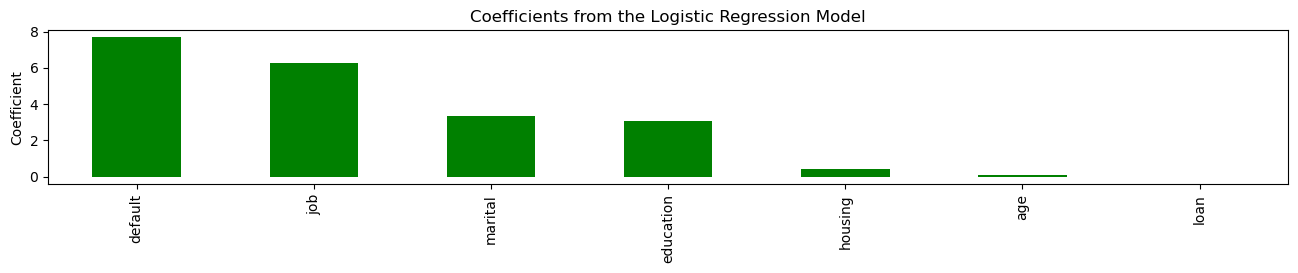

In [41]:
# plot coefficients of the logistic regression model
df_coeff = pd.DataFrame({'columns': feature_names, 
                         'coefficients': pipe.named_steps['log_reg'].coef_.tolist()[0]})

df_coeff.sort_values(by='coefficients',ascending=False, key=abs).plot.bar(
    x='columns', y='coefficients', legend=False, figsize=(16, 2),
    color=(df_coeff.sort_values(by='coefficients',ascending=False, key=abs)['coefficients'] > 0).map({True: 'g', False: 'r'}));
plt.xticks(rotation = 90);
plt.ylabel('Coefficient')
plt.title('Coefficients from the Logistic Regression Model')
plt.xlabel('')
plt.show();

In [43]:
df_coeff.sort_values(by='coefficients',ascending=False, key=abs)

columns  coefficients
4    default      7.685003
1        job      6.269962
2    marital      3.325768
3  education      3.065607
5    housing      0.434201
0        age      0.084320
6       loan     -0.036133

## Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [44]:
# create dictionaries to collect the results
train_time = {}
train_accuracy = {}
test_accuracy = {}

y_train_pred = {}
y_test_pred = {}

# difference between train and test accuracy
diff_accuracy = {}

In [45]:
# dictionary with the four models
models = {'Logistic Regression': LogisticRegression(random_state=4, n_jobs=-1),  
          'KNN': KNeighborsClassifier(n_jobs=-1), 
          'Decision Tree': DecisionTreeClassifier(random_state=4),
          'SVM': SVC(random_state=4)}

In [46]:
# loop over the four models
for name, model in models.items():
    
    # build pipeline
    pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    # measure CPU time of the fitting process
    start_time_ns = time.process_time_ns()
    pipe.fit(X_train, y_train)
    end_time_ns = time.process_time_ns()
    
    # predict
    y_train_pred[name] = pipe.predict(X_train)
    y_test_pred[name] = pipe.predict(X_test)
    
    # convert fit time into seconds
    train_time[name] = (end_time_ns - start_time_ns)/1e+9
    # compute train and test accuracy, as well as their difference
    train_accuracy[name] = accuracy_score(y_train, y_train_pred[name])
    test_accuracy[name] = accuracy_score(y_test, y_test_pred[name])
    diff_accuracy[name] = train_accuracy[name] - test_accuracy[name]

In [47]:
# create the dataframe with the model comparisons

results_df = pd.DataFrame({
    'Model' : [name for name, _ in models.items()],
    'Train Time' : [value for _, value in train_time.items()],
    'Train Accuracy' : [value for _, value in train_accuracy.items()],
    'Test Accuracy' : [value for _, value in test_accuracy.items()],
    'Accuracy Difference' : [value for _, value in diff_accuracy.items()]
})
results_df.set_index('Model', inplace=True)

results_df

Train Time  Train Accuracy  Test Accuracy  \
Model                                                            
Logistic Regression    0.609375        0.887711       0.887679   
KNN                    0.562500        0.892087       0.877857   
Decision Tree          0.578125        0.917858       0.860741   
SVM                   16.187500        0.887906       0.887581   

                     Accuracy Difference  
Model                                     
Logistic Regression             0.000032  
KNN                             0.014231  
Decision Tree                   0.057117  
SVM                             0.000324

**Train Time**

SVM has by far the highest training time. From [this source](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770), the training time complexities for the four models are:
- Logistic Regression: $\mathcal{O}(nd)$
- KNN: $\mathcal{O}(knd)$
- Decision Tree: $\mathcal{O}(n\log(n)\,d)$
- SVM: $\mathcal{O}(n^{2})$

where
- $n$ = number of training samples = 30,849
- $d$ = dimentionality of the data = 7
- $k$ = number of neighbors = 5 (default)

This tells us that, in fact, SVM has longer training time for large datasets.


**Train Accuracy**

The decision tree has the best train accuracy among the four models. It also has the highest difference between the train and test accuracy, which may indicate overfitting.


**Test Accuracy**

Logistic Regression has the best test accuracy among the four models. It also has the lowest difference between the train and test accuracy. But, as mentioned above, its test accuracy is slightly lower than the baseline score.

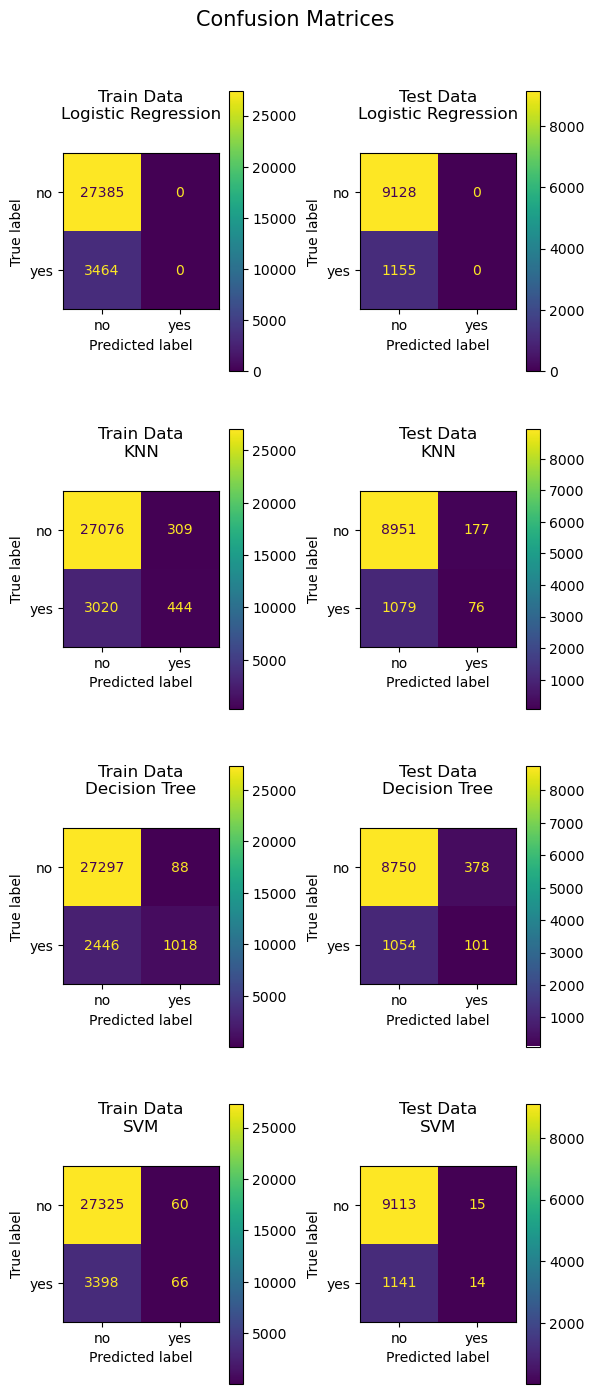

In [48]:
# confusion matrices

fig, ax = plt.subplots(4, 2, figsize=(6,14))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

i=0
n_cols=2

# loop over the four models
for name, model in models.items():

    # confusion matrix on train data
    cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, y_train_pred[name]), 
                                              display_labels = np.array(['no','yes']))
    cm_display_train.plot(ax=ax[i//n_cols,i%n_cols])
    ax[i//n_cols,i%n_cols].set_title('Train Data\n{}'.format(name), pad=25)

    # confusion matrix on test data
    cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_test_pred[name]), 
                                             display_labels = np.array(['no','yes']))
    
    cm_display_test.plot(ax=ax[(i+1)//n_cols,(i+1)%n_cols])
    ax[(i+1)//n_cols,(i+1)%n_cols].set_title('Test Data\n{}'.format(name), pad=25)
    
    i=i+2
    
fig.tight_layout()

In [49]:
## classification reports on train data

# loop over the four models
for name, model in models.items():
    print(name)
    print(classification_report(y_train, y_train_pred[name], target_names=['no','yes']))

Logistic Regression
              precision    recall  f1-score   support

          no       0.89      1.00      0.94     27385
         yes       0.00      0.00      0.00      3464

    accuracy                           0.89     30849
   macro avg       0.44      0.50      0.47     30849
weighted avg       0.79      0.89      0.83     30849

KNN
              precision    recall  f1-score   support

          no       0.90      0.99      0.94     27385
         yes       0.59      0.13      0.21      3464

    accuracy                           0.89     30849
   macro avg       0.74      0.56      0.58     30849
weighted avg       0.86      0.89      0.86     30849

Decision Tree
              precision    recall  f1-score   support

          no       0.92      1.00      0.96     27385
         yes       0.92      0.29      0.45      3464

    accuracy                           0.92     30849
   macro avg       0.92      0.65      0.70     30849
weighted avg       0.92      0.92   

In [50]:
## classification reports on test data

# loop over the four models
for name, model in models.items():
    print(name)
    print(classification_report(y_test, y_test_pred[name], target_names=['no','yes']))

Logistic Regression
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      9128
         yes       0.00      0.00      0.00      1155

    accuracy                           0.89     10283
   macro avg       0.44      0.50      0.47     10283
weighted avg       0.79      0.89      0.83     10283

KNN
              precision    recall  f1-score   support

          no       0.89      0.98      0.93      9128
         yes       0.30      0.07      0.11      1155

    accuracy                           0.88     10283
   macro avg       0.60      0.52      0.52     10283
weighted avg       0.83      0.88      0.84     10283

Decision Tree
              precision    recall  f1-score   support

          no       0.89      0.96      0.92      9128
         yes       0.21      0.09      0.12      1155

    accuracy                           0.86     10283
   macro avg       0.55      0.52      0.52     10283
weighted avg       0.82      0.86   

As mentioned above, our simple logistic regression model can't predict the `yes`-class. The other three simple models can predict the `yes`-class, but their recall scores and f1-scores are too low.

## Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric.

### Data Preparation

In [8]:
# Start again from the beginning: 
# create a new dataframe df_clean which will be the cleaned version of the original dataframe d.
df_clean = df.copy()

# As mentioned above in Problem 3: the 'duration'-feature should be discarded if the intention is 
# to have a realistic predictive model.
df_clean.drop(columns=['duration'], inplace=True)

In [9]:
# set target column
target_col = 'y'

#### Remove Multicollinearity

In [10]:
# select numeric columns
num_cols = df_clean.select_dtypes(include='number').columns

# measure multicollinearity
sklearn_vif(num_cols, df_clean).sort_values(by='VIF', ascending=False)

VIF
euribor3m       64.342881
emp.var.rate    33.070180
nr.employed     31.662087
cons.price.idx   6.337933
cons.conf.idx    2.648960
previous         1.795642
pdays            1.612602
campaign         1.033689
age              1.018878

In [11]:
# remove 'euribor3m'
df_clean.drop(columns=['euribor3m'], inplace=True)

# measure multicollinearity again
num_cols = df_clean.select_dtypes(include='number').columns
sklearn_vif(num_cols, df_clean).sort_values(by='VIF', ascending=False)

VIF
emp.var.rate    24.120363
nr.employed     13.253160
cons.price.idx   5.520024
previous         1.795575
pdays            1.612344
cons.conf.idx    1.314381
campaign         1.026412
age              1.018681

In [12]:
# remove 'emp.var.rate'
df_clean.drop(columns=['emp.var.rate'], inplace=True)

# measure multicollinearity again
num_cols = df_clean.select_dtypes(include='number').columns
sklearn_vif(num_cols, df_clean).sort_values(by='VIF', ascending=False)

VIF
nr.employed     1.845401
previous        1.791443
pdays           1.612328
cons.price.idx  1.410502
cons.conf.idx   1.056123
campaign        1.026364
age             1.018556

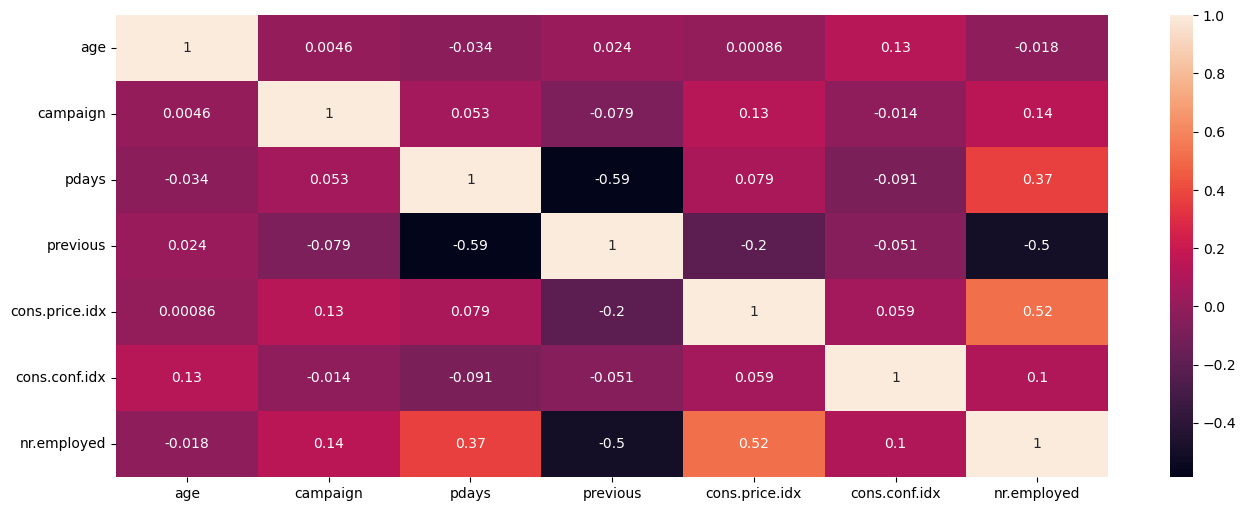

In [13]:
# heatmap plot of the correlations of the numeric features
plt.figure(figsize=(16, 6))
sns.heatmap(df_clean.corr(), annot=True);

#### Analyse Target

We encode the target variable to integers and label the `yes`-class as the positive class:

In [14]:
# transform target column to integers
df_clean[target_col] = df_clean[target_col].replace({'yes':1, 'no':0})

##### Univariate Analysis

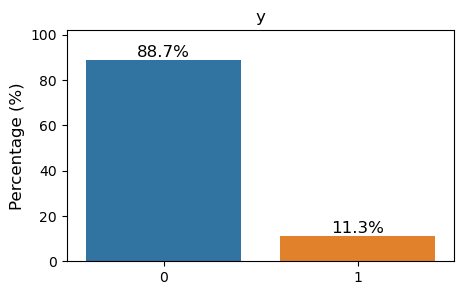

In [15]:
# Calculate and plot (bar plot) the percentage of unique values in the target column.

df_col = df_clean[target_col].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()

plt.figure(figsize=(5,3))
g = sns.barplot(x='index', y='Percentage (%)', data=df_col)

g.set_xticks(g.get_xticks(), fontsize = 12)
g.set_yticks(g.get_yticks(), fontsize = 12)
g.set_title(target_col, fontsize=12)
g.set_xlabel('')
g.set_ylabel('Percentage (%)', fontsize = 12)
    
# add percentages as text to the bars
for container in g.containers:
    g.bar_label(container, fmt='%.1f%%', fontsize=12)
bottom, upper = g.get_ylim()
g.set_ylim(bottom, upper+2)
plt.subplots_adjust(hspace=5)

##### Bivariate Analysis

###### Numerical Value Relationship

In [16]:
# statistics
df_clean.groupby(target_col).describe()

age                                                     campaign  \
     count       mean        std   min   25%   50%   75%   max    count   
y                                                                         
0  36548.0  39.911185   9.898132  17.0  32.0  38.0  47.0  95.0  36548.0   
1   4640.0  40.913147  13.837476  17.0  31.0  37.0  50.0  98.0   4640.0   

                                                   pdays              \
       mean       std  min  25%  50%  75%   max    count        mean   
y                                                                      
0  2.633085  2.873438  1.0  1.0  2.0  3.0  56.0  36548.0  984.113878   
1  2.051724  1.666245  1.0  1.0  2.0  2.0  23.0   4640.0  792.035560   

                                               previous                      \
          std  min    25%    50%    75%    max    count      mean       std   
y                                                                             
0  120.656868  0.0  999.0  999.0  999.0  999.0  36548.0  0.132374  0.409199   
1  403.407181  0.0  999.0  999.0  999.0  999.0   4640.0  0.492672  0.860344   

                           cons.price.idx                               \
   min  25%  50%  75%  max          count       mean       std     min   
y                                                                        
0  0.0  0.0  0.0  0.0  7.0        36548.0  93.603757  0.558993  92.201   
1  0.0  0.0  0.0  1.0  6.0         4640.0  93.354386  0.676644  92.201   

                                  cons.conf.idx                             \
      25%     50%     75%     max         count       mean       std   min   
y                                                                            
0  93.075  93.918  93.994  94.767       36548.0 -40.593097  4.391155 -50.8   
1  92.893  93.200  93.918  94.767        4640.0 -39.789784  6.139668 -50.8   

                          nr.employed                                          \
    25%   50%   75%   max       count         mean        std     min     25%   
y                                                                               
0 -42.7 -41.8 -36.4 -26.9     36548.0  5176.166600  64.571979  4963.6  5099.1   
1 -46.2 -40.4 -36.1 -26.9      4640.0  5095.115991  87.572641  4963.6  5017.5   

                           
      50%     75%     max  
y                          
0  5195.8  5228.1  5228.1  
1  5099.1  5191.0  5228.1

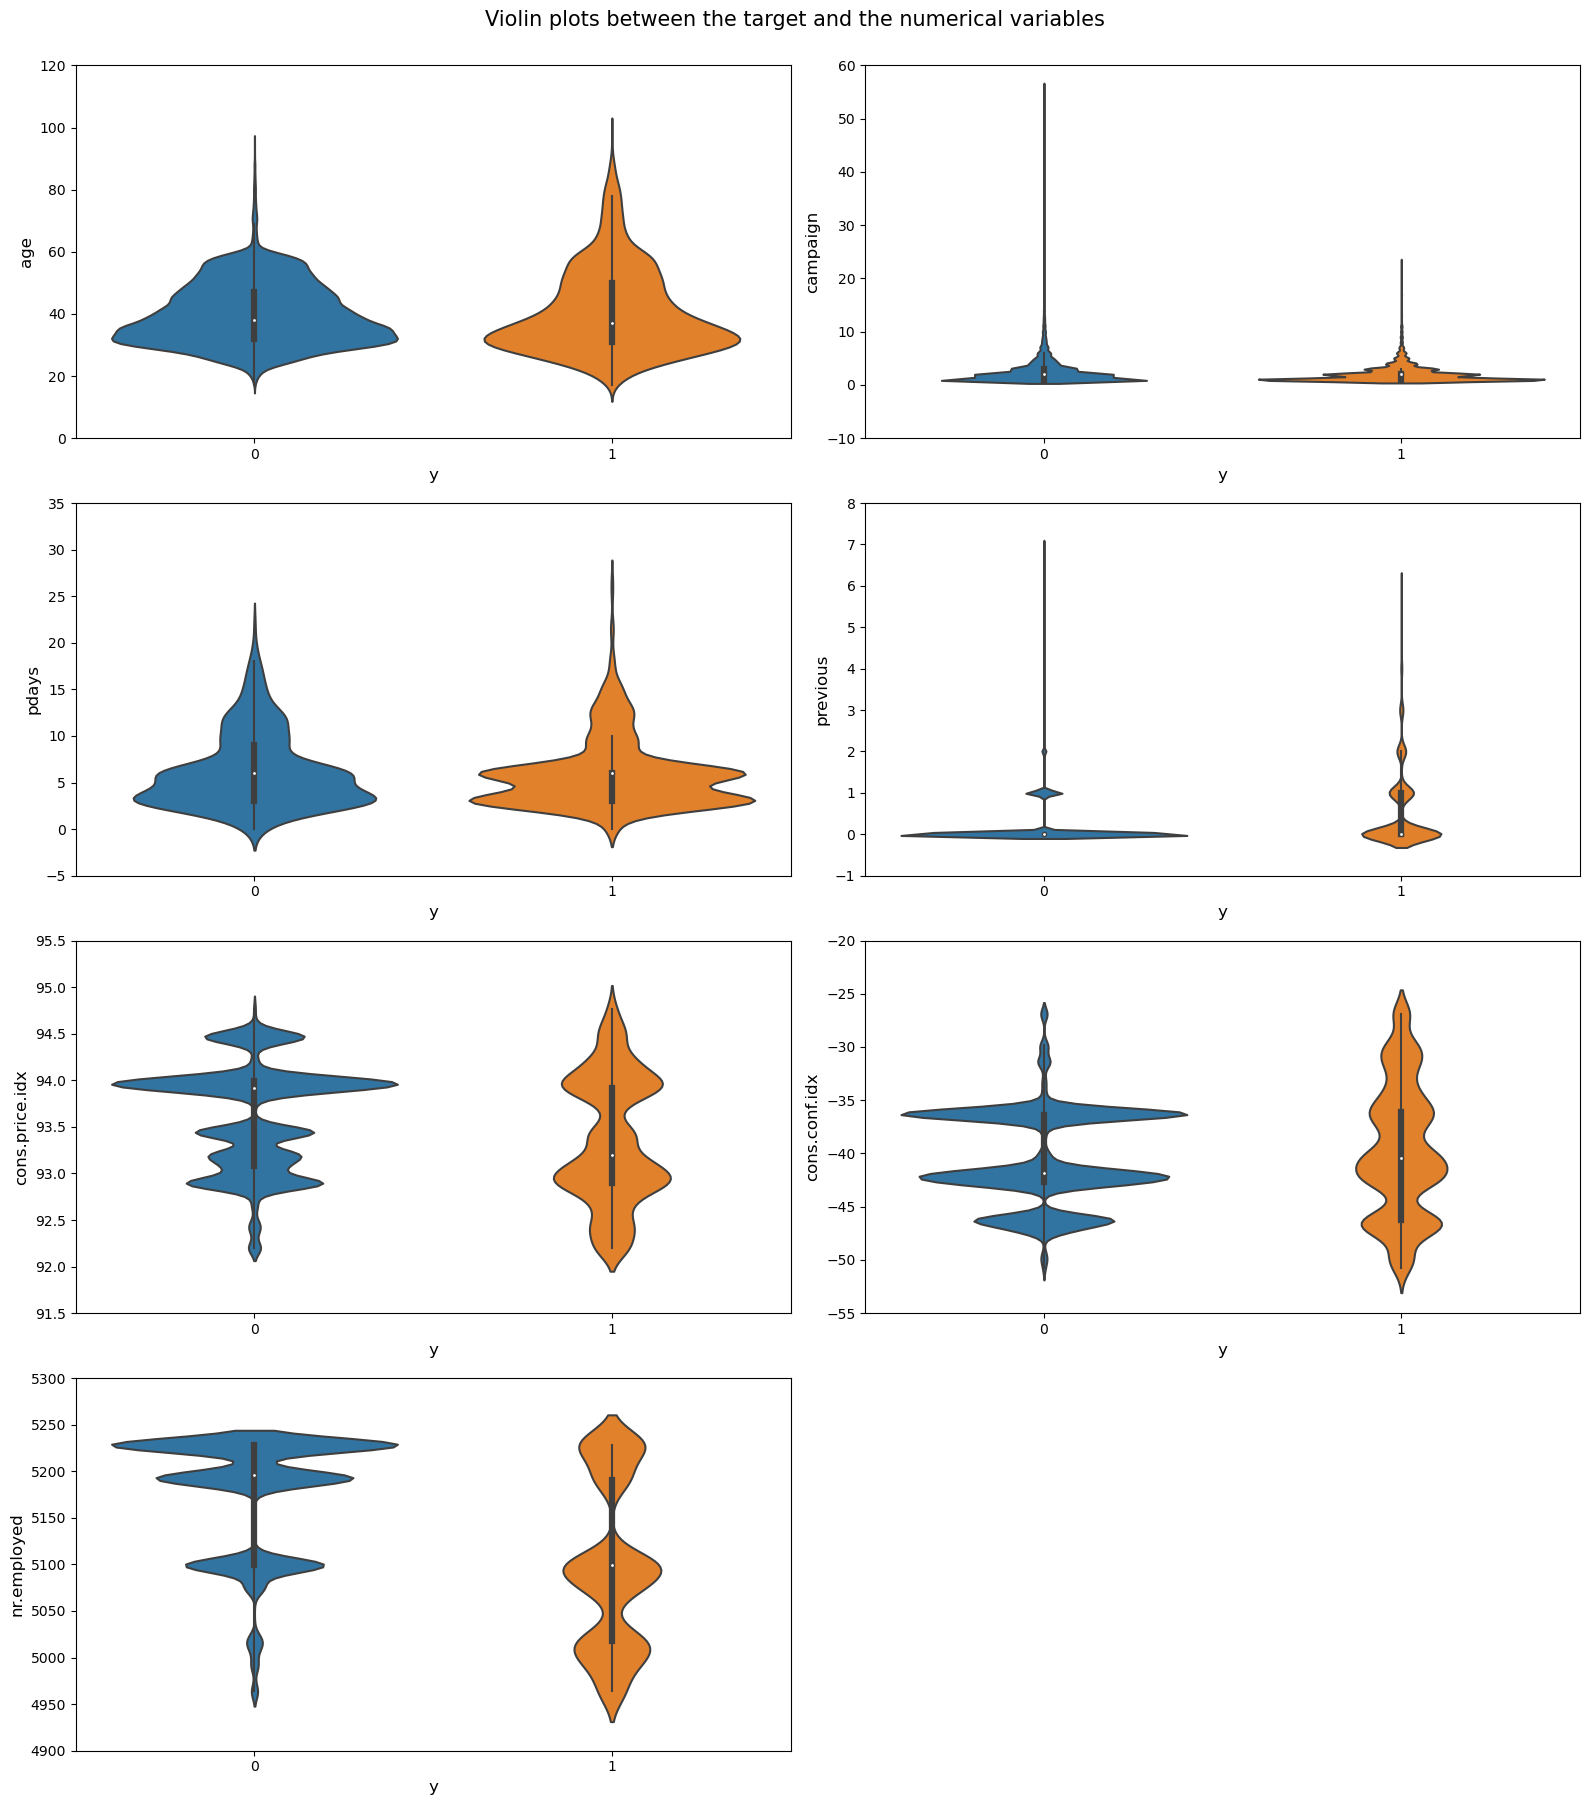

In [17]:
# violin plots between the target and the numerical variables

i=0
n_cols = 2

num_cols = df_clean.drop(columns=target_col).select_dtypes(include='number').columns

fig, ax = plt.subplots(math.ceil((len(num_cols)/n_cols)), n_cols, figsize=(16,18))
fig.suptitle('Violin plots between the target and the numerical variables', fontsize=15, y=1.)

for col in num_cols:
    if col=='pdays':
        g = sns.violinplot(y=col, x=target_col, data=df_clean[df_clean[col]<999], ax=ax[i//n_cols,i%n_cols])
    else:
        g = sns.violinplot(y=col, x=target_col, data=df_clean, ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_ylabel(col, fontsize = 12)
    g.set_xlabel(target_col, fontsize = 12)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(num_cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

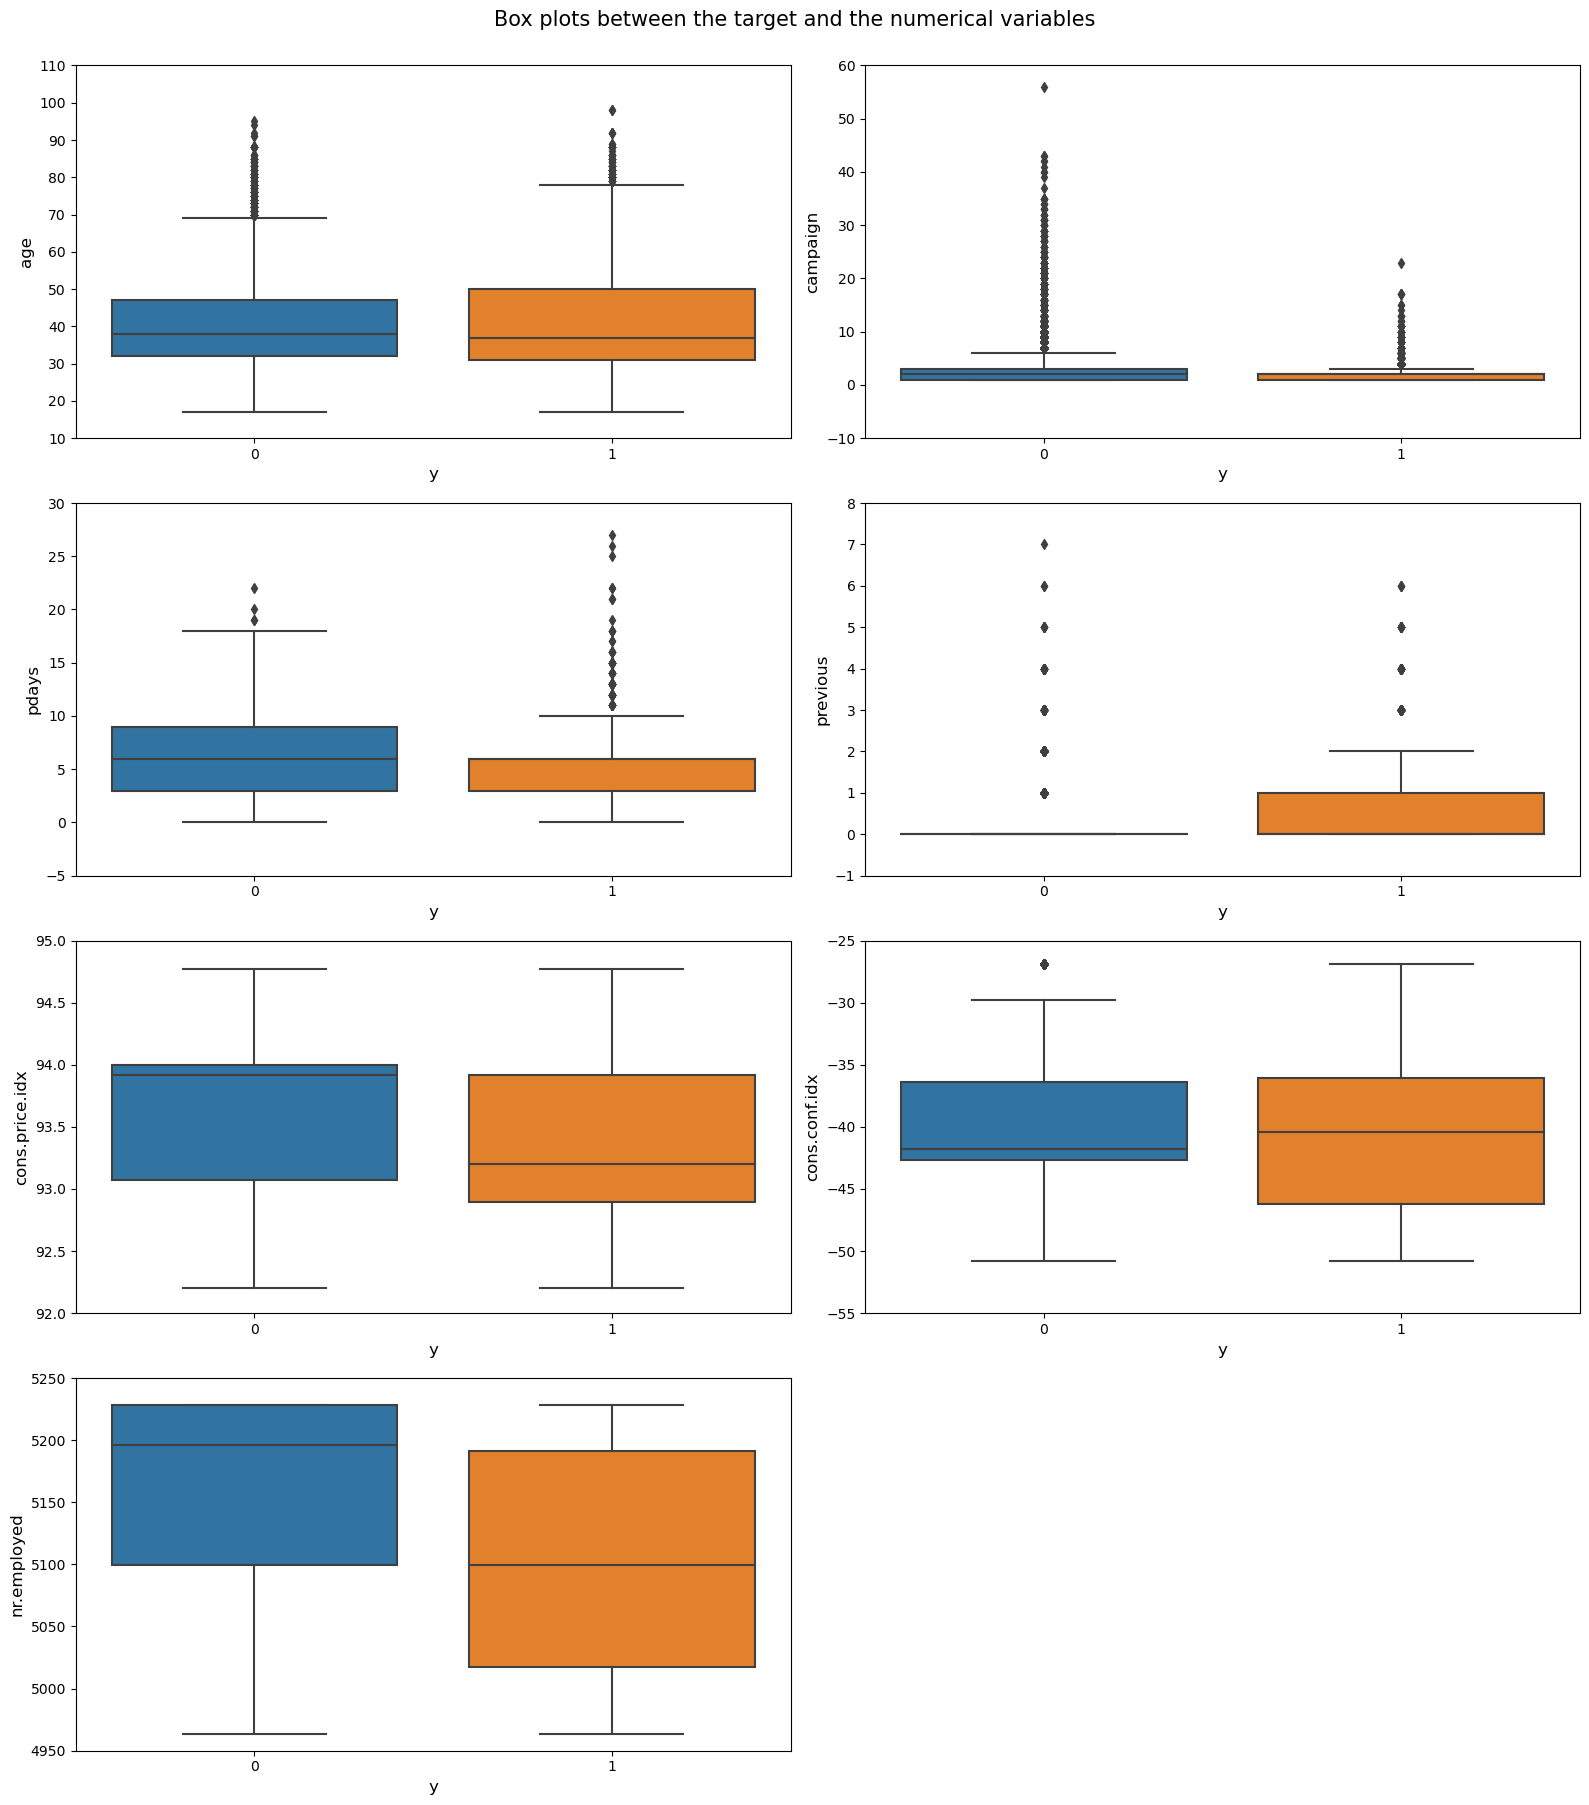

In [18]:
# box plots between the target and the numerical variables

i=0
n_cols = 2

num_cols = df_clean.drop(columns=target_col).select_dtypes(include='number').columns

fig, ax = plt.subplots(math.ceil((len(num_cols)/n_cols)), n_cols, figsize=(16,18))
fig.suptitle('Box plots between the target and the numerical variables', fontsize=15, y=1.)

for col in num_cols:
    if col=='pdays':
        g = sns.boxplot(y=col, x=target_col, data=df_clean[df_clean[col]<999], ax=ax[i//n_cols,i%n_cols])
    else:
        g = sns.boxplot(y=col, x=target_col, data=df_clean, ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_ylabel(col, fontsize = 12)
    g.set_xlabel(target_col, fontsize = 12)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(num_cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

We remove the `age` and `campaign`-features since statistics between the two target classes are similar in each of the two features:

In [19]:
# remove non-relevant features
df_clean.drop(columns=['age', 'campaign'], inplace=True)

###### Categorical Value Relationship

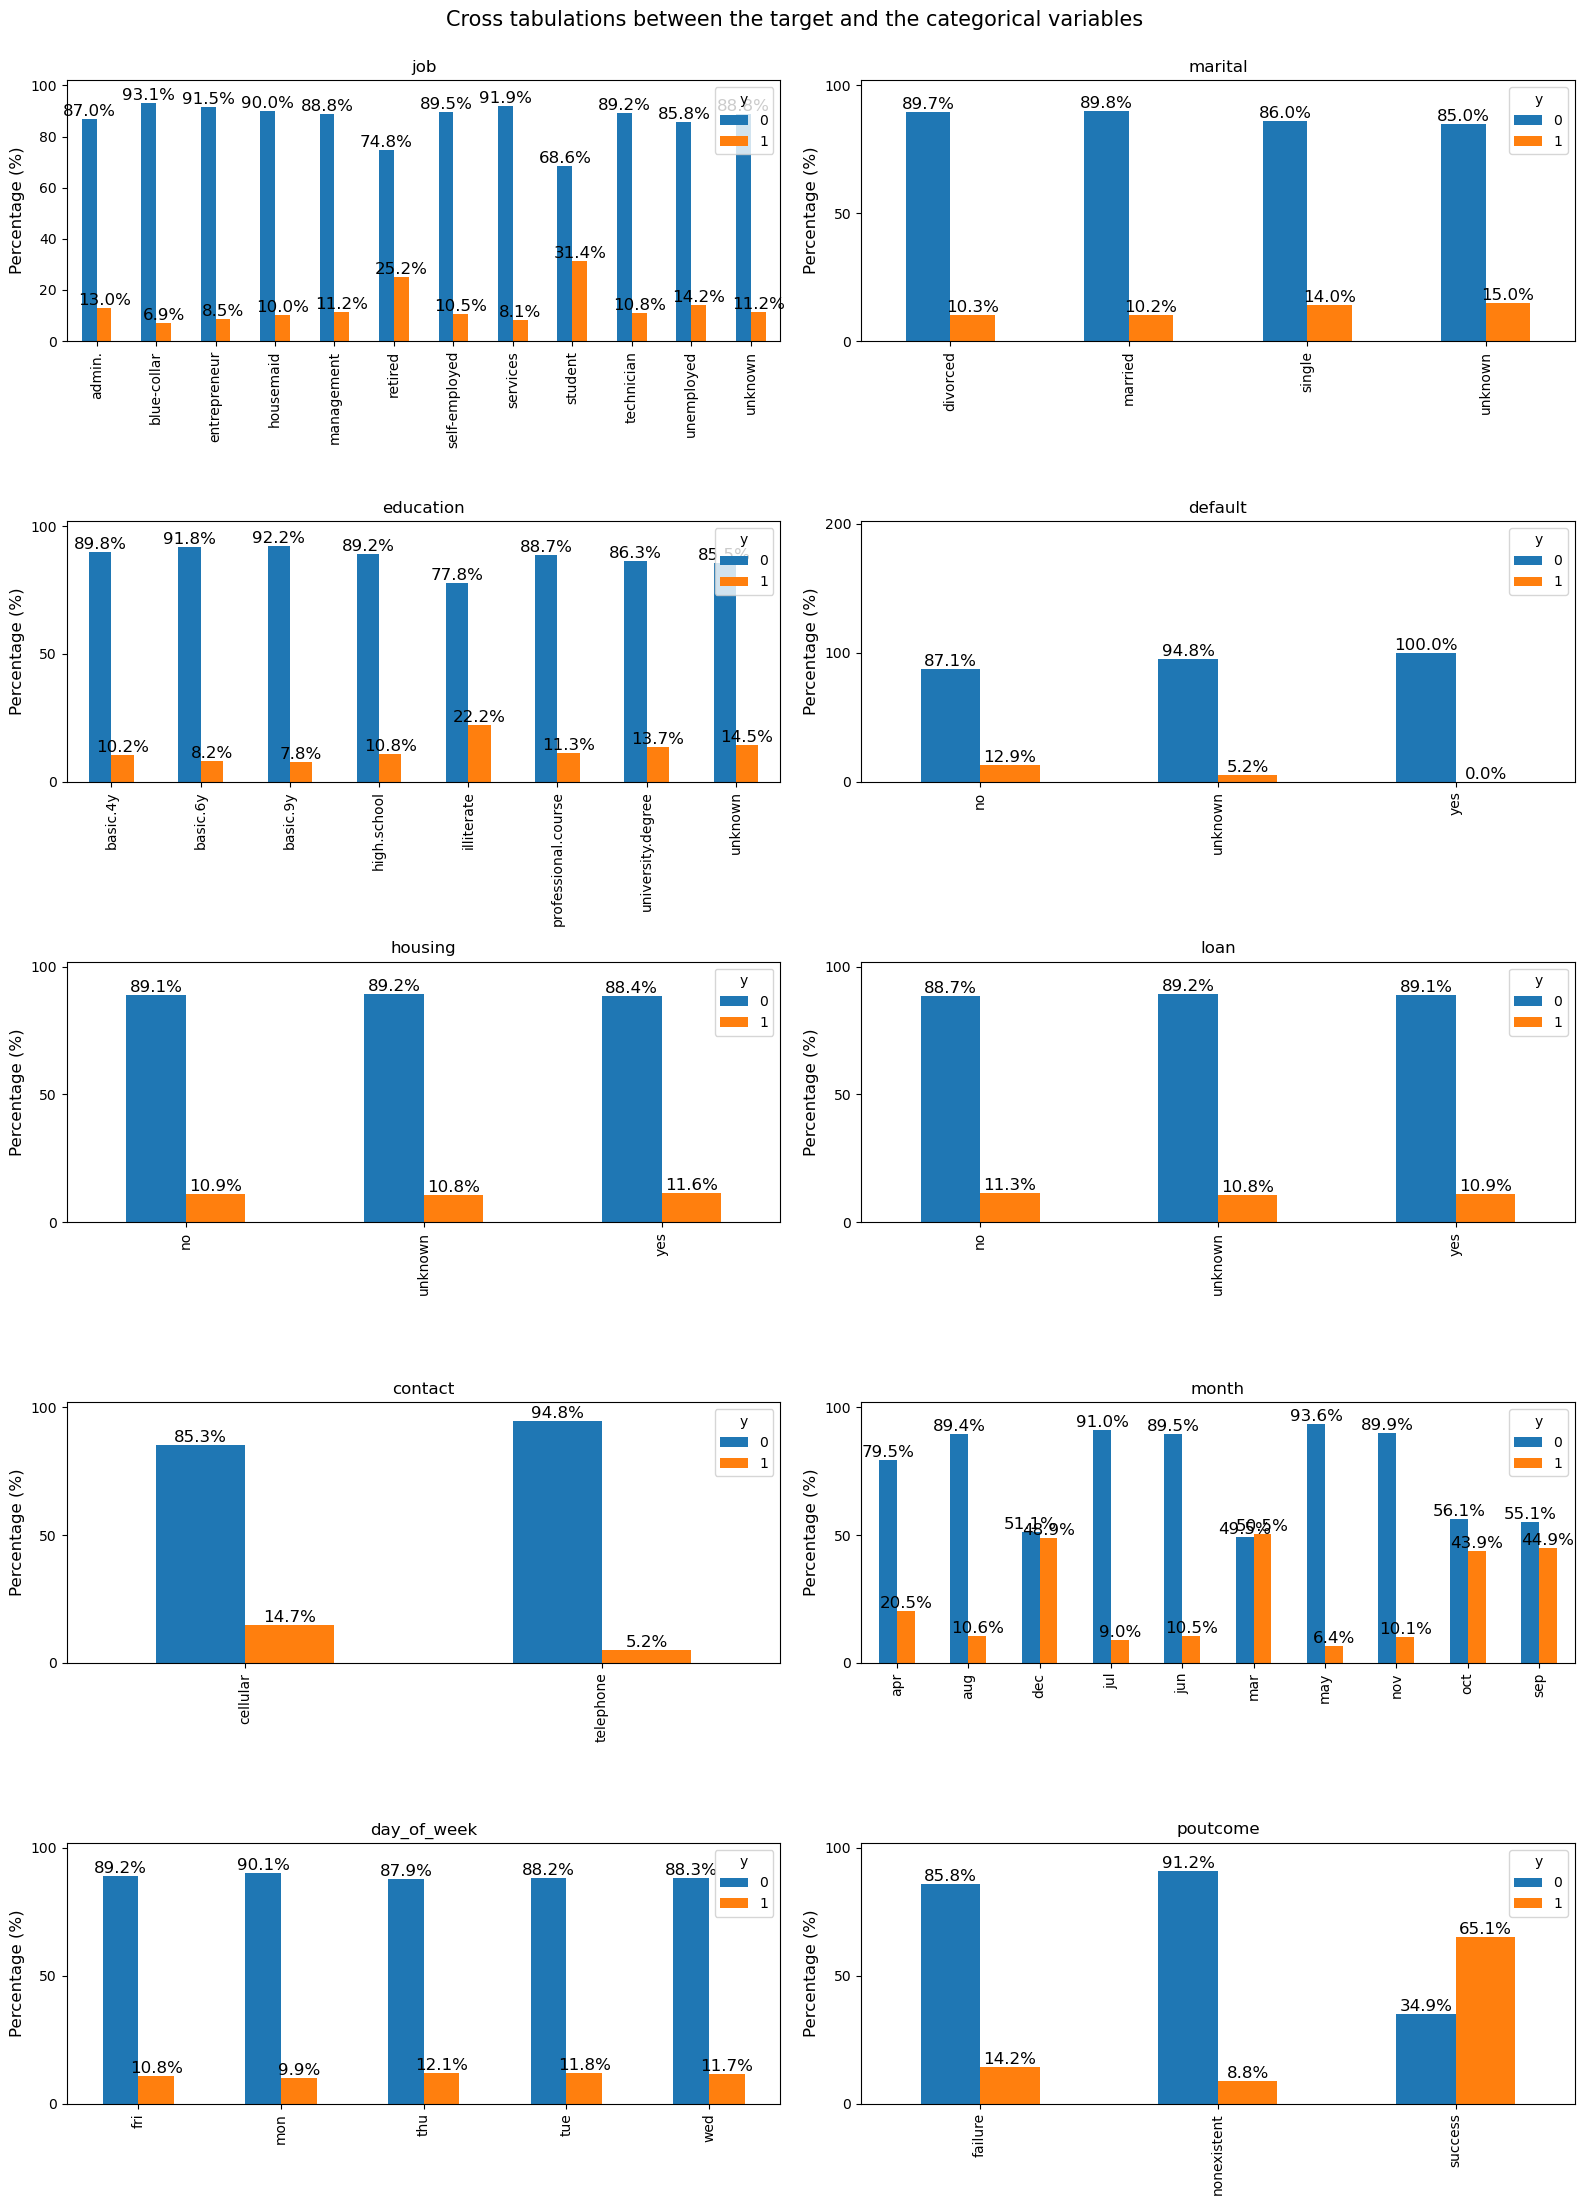

In [20]:
# cross tabulations between the target and the categorical variables

i=0
n_cols = 2

obj_cols = df_clean.select_dtypes(include='object').columns

fig, ax = plt.subplots(math.ceil((len(obj_cols)/n_cols)), n_cols, figsize=(16,22))
fig.suptitle('Cross tabulations between the target and the categorical variables', fontsize=15, y=1.)

for col in obj_cols:
    
    # Creating crosstab
    crosstb = 100. * pd.crosstab(df_clean[col], df_clean[target_col], normalize='index')

    # Creating barplot
    g = crosstb.plot.bar(rot=0, ax=ax[i//n_cols,i%n_cols])
      
    g.set_xticks(g.get_xticks(), fontsize = 12)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    ax[i//n_cols,i%n_cols].set_xticklabels(ax[i//n_cols,i%n_cols].get_xticklabels(), rotation = 90)
    g.set_title(col, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    
    # add percentages as text to the bars
    for container in g.containers:
        g.bar_label(container, fmt='%.1f%%', fontsize=12)
    bottom, upper = g.get_ylim()
    g.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=5)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(obj_cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

We remove the `marital`-, `housing`-, `loan`-, and `day_of_week`-features since target-related statistics are similar across those feature's categories. I don't think the `contact`-feature is relevant either, so I will drop it as well:

In [21]:
# remove non-relevant features
df_clean.drop(columns=['marital', 'housing', 'loan', 'day_of_week', 'contact'], inplace=True)

In [22]:
# new shape of the dataframe
df_clean.shape

(41188, 11)

#### Explore Numeric Columns

In [23]:
# descriptive statistics of our numeric data
df_clean.drop(columns=target_col).describe()

pdays      previous  cons.price.idx  cons.conf.idx   nr.employed
count  41188.000000  41188.000000    41188.000000   41188.000000  41188.000000
mean     962.475454      0.172963       93.575664     -40.502600   5167.035911
std      186.910907      0.494901        0.578840       4.628198     72.251528
min        0.000000      0.000000       92.201000     -50.800000   4963.600000
25%      999.000000      0.000000       93.075000     -42.700000   5099.100000
50%      999.000000      0.000000       93.749000     -41.800000   5191.000000
75%      999.000000      0.000000       93.994000     -36.400000   5228.100000
max      999.000000      7.000000       94.767000     -26.900000   5228.100000

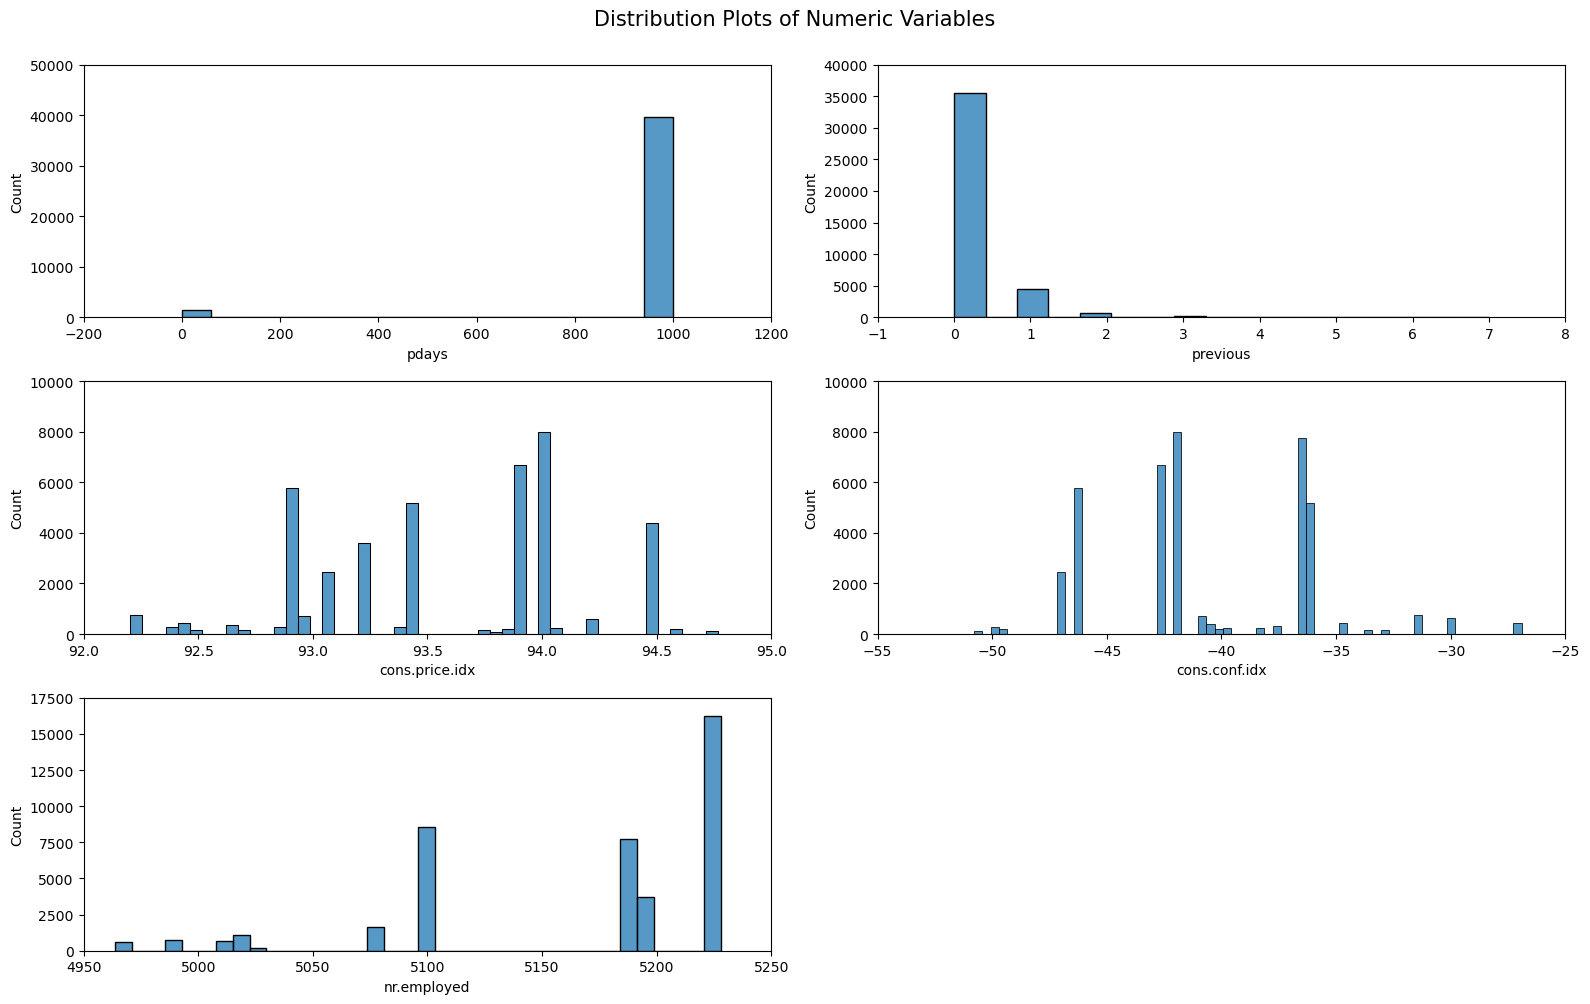

In [24]:
# distribution plots of numeric variables

i=0
n_cols = 2

num_cols = df_clean.drop(columns=target_col).select_dtypes(include='number').columns

fig, ax = plt.subplots(math.ceil((len(num_cols)/n_cols)), n_cols, figsize=(16,10))
fig.suptitle('Distribution Plots of Numeric Variables', fontsize=15, y=1.)

for col in num_cols:
    g = sns.histplot(x=df_clean[col], ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    g.set_yticks(g.get_yticks(), fontsize = 12)

    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(num_cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

The `previous`-feature is right-skewed.

As mentioned above in Problem 3 about the `pdays`-feature: `999` means the client was not previously contacted.

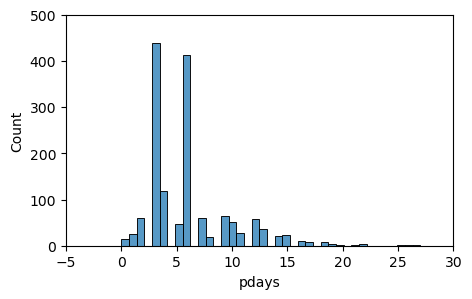

In [25]:
# distribution plot of the pdays-feature for clients that were previously contacted
plt.figure(figsize=(5,3))
g = sns.histplot(x=df_clean[df_clean['pdays']<999]['pdays'])
    
g.set_xticks(g.get_xticks(), fontsize = 12)
g.set_yticks(g.get_yticks(), fontsize = 12);

Hence, we will not clean outliers from the `pdays`-feature.

#### Handle Outliers

In [26]:
# calculate percentage of outliers using the detect_outliers_zscore() function
outlier_zscore_dic = {}
for col in num_cols:
    # skip 'pdays'-feature
    if col=='pdays':
        continue
    outlier_val = detect_outliers_zscore(df_clean.dropna(subset=col), col)
    if outlier_val > 0:
        outlier_zscore_dic[col] = outlier_val

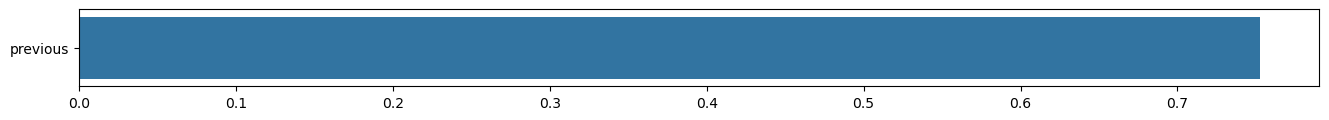

In [27]:
# sort the columns by their percentage of outliers
outlier_zscore_dic_sorted = {}
sorted_keys = sorted(outlier_zscore_dic, key=outlier_zscore_dic.get, reverse=True)

for w in sorted_keys:
    outlier_zscore_dic_sorted[w] = outlier_zscore_dic[w]
    
# plot percentage of outliers
plt.figure(figsize=(16, 1))
sns.barplot(x=list(outlier_zscore_dic_sorted.values()), y=list(outlier_zscore_dic_sorted.keys()));

In [28]:
# drop outliers
for col, _ in outlier_zscore_dic.items():
        
    zscore = np.abs(stats.zscore(df_clean[col]))
    
    size_before = df_clean.shape[0]
    df_clean.drop(df_clean[np.abs(stats.zscore(df_clean[col]))>4.5].index, inplace=True)
    size_after = df_clean.shape[0]
    
    print('Cleaned {:.2f}% percentage of {}.'.format((size_before-size_after)*100./size_before, col))

Cleaned 0.75% percentage of previous.


In [29]:
# new shape of the dataframe
df_clean.shape

(40878, 11)

#### Explore Categorical Columns

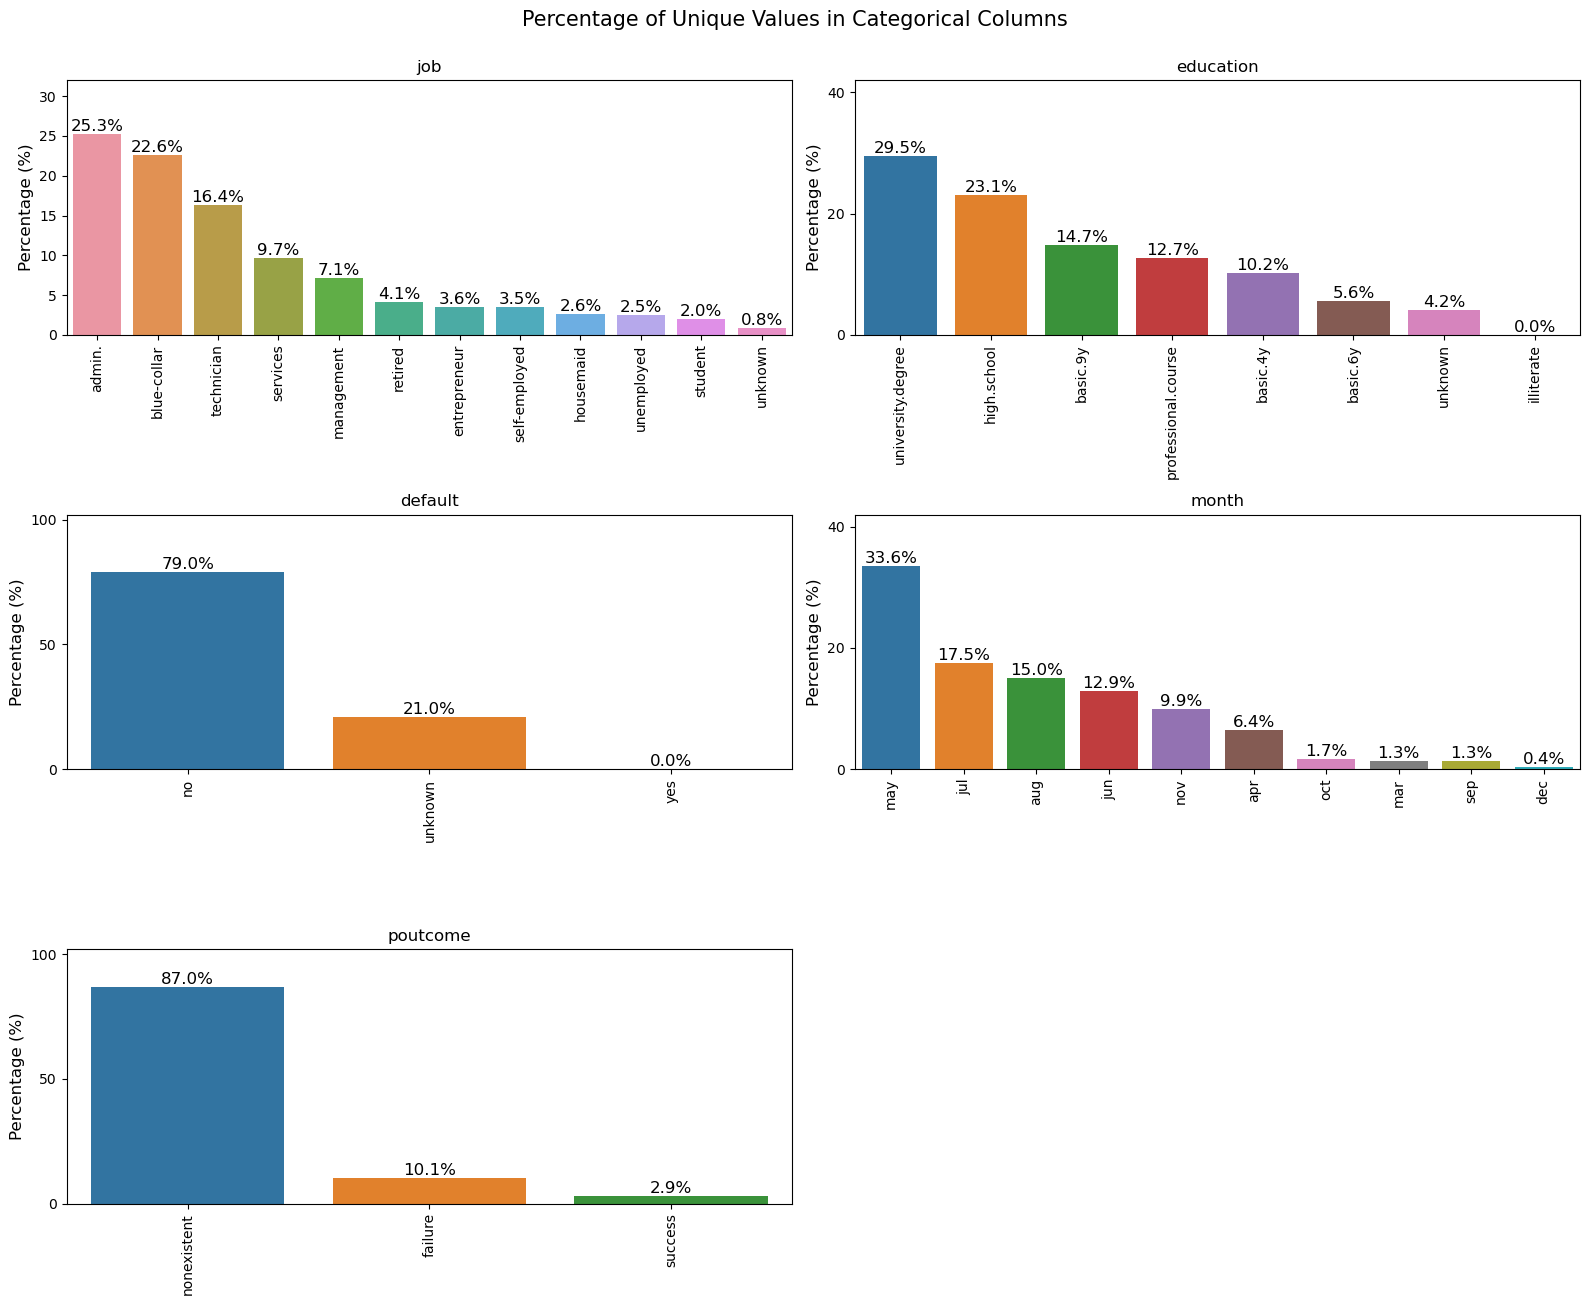

In [30]:
# Calculate and plot (bar plot) the percentage of unique values in categorical columns.

i=0
n_cols = 2
obj_cols = df_clean.select_dtypes(include='object').columns

fig, ax = plt.subplots(math.ceil((len(obj_cols)/n_cols)), n_cols, figsize=(16,13))
fig.suptitle('Percentage of Unique Values in Categorical Columns', fontsize=15, y=1.)

for col in obj_cols:
    df_col = df_clean[col].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()
 
    g = sns.barplot(x='index', y='Percentage (%)', data=df_col, ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    ax[i//n_cols,i%n_cols].set_xticklabels(ax[i//n_cols,i%n_cols].get_xticklabels(), rotation = 90)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(col, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    
    # add percentages as text to the bars
    for container in g.containers:
        g.bar_label(container, fmt='%.1f%%', fontsize=12)
    bottom, upper = g.get_ylim()
    g.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=5)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(obj_cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()

fig.tight_layout()

As we saw earlier:
- The data has imbalanced categorical features.
- We decide to remove the `iliterate`-category in the `education`-feature and the `yes`-category in the `default`-feature due to their low representation (about 0%):

In [31]:
# remove low-representative categories
df_clean = df_clean[~(df_clean['education'].isin(['illiterate']))]
df_clean = df_clean[~(df_clean['default'].isin(['yes']))]

As we saw earlier:

Missing values (labeled as `unknown`):
 - The `default` feature has 21% missing values. The remaining values are all labeled as `no`. We decide to treat the `unknown`-category as a possible class label and keep it.
 - The remaining features have less than 4.3% missing values each, and we will impute them as part of the pipeline in the Modeling section below.

In [32]:
# replace 'unknown' with NaN (except for the 'default' feature)
for col in list(df_clean.drop(columns='default').select_dtypes(include='object').columns):
    df_clean[col] = np.where(df_clean[col]=='unknown', np.nan, df_clean[col]) 

### Modeling

#### Train - Test - Split

In [33]:
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(30642, 10)
(10215, 10)
(30642,)
(10215,)


In [34]:
# create dictionaries to collect the results
mean_fit_time = {}
mean_score_time = {}
best_score = {}
train_time = {}
train_avg_precision = {}
test_avg_precision = {}
train_accuracy = {}
test_accuracy = {}

# difference between train and test scores
diff_avg_precision = {}
diff_accuracy = {}

y_train_pred = {}
y_test_pred = {}

####  Define Three Different Pipeline Preprocessors

In [35]:
## define variable types

# numeric variables
num_cols = list(X.select_dtypes(include='number').columns)

# nominal variables
nominal_cols = list(X.select_dtypes(include='object').columns)

##### Pipeline Preprocessor 1

In [104]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Target encoded and imputed via the IterativeImputer.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', TargetEncoder(handle_unknown='return_nan', handle_missing='return_nan')),
        ('imputer', IterativeImputer(initial_strategy='median', random_state=0))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

##### Pipeline Preprocessor 2

In [112]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Imputed via the SimpleImputer and encoded via the EmbeddingEncoder.
nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', EmbeddingEncoder(task='classification'))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

##### Pipeline Preprocessor 3

In [54]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Imputed via the SimpleImputer and encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

#### Hyperparameter Tuning

Since the data is heavily imbalanced and we care more about the positive class, we choose the average precision score as the appropriate metric.

##### Logistic Regression

###### Pipeline Preprocessor 1

In [44]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('log_reg', LogisticRegression(random_state=4, max_iter=500, solver='saga', class_weight='balanced', n_jobs=-1))
    ]
)

# define hyperparameter search space
param_dict =  {'log_reg__penalty': Categorical(['none','l1','l2','elasticnet']),
               'log_reg__l1_ratio': Real(0, 1, prior='uniform'),
               'log_reg__C': Real(1e-5, 1, prior='log-uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.347 total time=   3.6s
[CV 2/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.329 total time=   0.8s
[CV 3/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.361 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.394 total time=   1.1s
[CV 2/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.368 total time=   1.2s
[CV 3/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.410 total time=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fit

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.06541747441147652, log_reg__l1_ratio=0.6058878442178532, log_reg__penalty=l2;, score=0.399 total time=   0.5s
[CV 2/3] END log_reg__C=0.06541747441147652, log_reg__l1_ratio=0.6058878442178532, log_reg__penalty=l2;, score=0.371 total time=   0.5s
[CV 3/3] END log_reg__C=0.06541747441147652, log_reg__l1_ratio=0.6058878442178532, log_reg__penalty=l2;, score=0.416 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.061127771219583515, log_reg__l1_ratio=0.0, log_reg__penalty=l2;, score=0.399 total time=   0.6s
[CV 2/3] END log_reg__C=0.061127771219583515, log_reg__l1_ratio=0.0, log_reg__penalty=l2;, score=0.371 total time=   0.5s
[CV 3/3] END log_reg__C=0.061127771219583515, log_reg__l1_ratio=0.0, log_reg__penalty=l2;, score=0.416 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.02429500733480837, log_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.019762996343252657, log_reg__l1_ratio=0.9793488946359827, log_reg__penalty=l1;, score=0.389 total time=   0.4s
[CV 2/3] END log_reg__C=0.019762996343252657, log_reg__l1_ratio=0.9793488946359827, log_reg__penalty=l1;, score=0.359 total time=   0.4s
[CV 3/3] END log_reg__C=0.019762996343252657, log_reg__l1_ratio=0.9793488946359827, log_reg__penalty=l1;, score=0.408 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.004950506358899878, log_reg__l1_ratio=0.9385453722318454, log_reg__penalty=l2;, score=0.400 total time=   0.4s
[CV 2/3] END log_reg__C=0.004950506358899878, log_reg__l1_ratio=0.9385453722318454, log_reg__penalty=l2;, score=0.367 total time=   0.4s
[CV 3/3] END log_reg__C=0.004950506358899878, log_reg__l1_ratio=0.9385453722318454, log_reg__penalty=l2;, score=0.420 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('encoder',
                                                                                           TargetEncoder(handle_missing='return_nan',
                                                                                                         handle_unknown='return_nan')),
                                                                                          ('imputer',
                                                                                           Iterativ...
                                                            n_jobs=-1,
                                                            random_state=4,
                                                            solver='saga'))]),
              random_state=10, scoring='average_precision',
              search_spaces={'log_reg__C': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'log_reg__l1_ratio': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'log_reg__penalty': Categorical(categories=('none', 'l1', 'l2', 'elasticnet'), prior=None)},
              verbose=4)

In [45]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.39624262712456676

In [46]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('log_reg__C', 0.02429500733480837),
             ('log_reg__l1_ratio', 0.9896389113418892),
             ('log_reg__penalty', 'l2')])

In [47]:
# collect the results
best_score['Logistic Regression'] = opt.best_score_
mean_fit_time['Logistic Regression'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['Logistic Regression'] = opt.cv_results_['mean_score_time'].mean()

###### Pipeline Preprocessor 2

In [90]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('log_reg', LogisticRegression(random_state=4, max_iter=500, solver='saga', class_weight='balanced', n_jobs=-1))
    ]
)

# define hyperparameter search space
param_dict =  {'log_reg__penalty': Categorical(['none','l1','l2','elasticnet']),
               'log_reg__l1_ratio': Real(0, 1, prior='uniform'),
               'log_reg__C': Real(1e-5, 1, prior='log-uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=30,  # we use only 30 here as fitting takes more time
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.350 total time=  10.4s
[CV 2/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.331 total time=   8.0s
[CV 3/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.363 total time=   7.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.398 total time=  10.2s
[CV 2/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.365 total time=  12.1s
[CV 3/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.414 total time=   8.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fit

[CV 3/3] END log_reg__C=0.019539950231874288, log_reg__l1_ratio=0.005507098387165233, log_reg__penalty=elasticnet;, score=0.415 total time=   8.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.0021250944123133173, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.411 total time=  10.3s
[CV 2/3] END log_reg__C=0.0021250944123133173, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.381 total time=  11.3s
[CV 3/3] END log_reg__C=0.0021250944123133173, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.414 total time=  13.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=1.1827945718186052e-05, log_reg__l1_ratio=0.9963452788532399, log_reg__penalty=none;, score=0.408 total time=  12.1s
[CV 2/3] END log_reg__C=1.1827945718186052e-05, log_reg__l1_ratio=0.9963452788532399, log_reg__penalty=none;, score=0.372 total time=  10.5s
[CV 3/3] END log_reg__C=1.1827945718186052e-05, log_reg__l1_ratio=0.9963452788

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           EmbeddingEncoder(task='classification')...
                                                            random_state=4,
                                                            solver='saga'))]),
              n_iter=30, random_state=10, scoring='average_precision',
              search_spaces={'log_reg__C': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'log_reg__l1_ratio': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'log_reg__penalty': Categorical(categories=('none', 'l1', 'l2', 'elasticnet'), prior=None)},
              verbose=4)

In [91]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.40251599099212765

In [92]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('log_reg__C', 6.322792431274491e-05),
             ('log_reg__l1_ratio', 1.0),
             ('log_reg__penalty', 'none')])

In [93]:
# collect the results
best_score['Logistic Regression'] = opt.best_score_
mean_fit_time['Logistic Regression'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['Logistic Regression'] = opt.cv_results_['mean_score_time'].mean()

###### Pipeline Preprocessor 3

In [55]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('log_reg', LogisticRegression(random_state=4, max_iter=500, solver='saga', class_weight='balanced', n_jobs=-1))
    ]
)

# define hyperparameter search space
param_dict =  {'log_reg__penalty': Categorical(['none','l1','l2','elasticnet']),
               'log_reg__l1_ratio': Real(0, 1, prior='uniform'),
               'log_reg__C': Real(1e-5, 1, prior='log-uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.356 total time=   4.3s
[CV 2/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.339 total time=   0.9s
[CV 3/3] END log_reg__C=1.7481779994213116e-05, log_reg__l1_ratio=0.23456973671852394, log_reg__penalty=l2;, score=0.371 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.414 total time=   0.9s
[CV 2/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.376 total time=   1.1s
[CV 3/3] END log_reg__C=0.9066887631952211, log_reg__l1_ratio=0.0760884268996176, log_reg__penalty=l2;, score=0.421 total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fit

[CV 2/3] END log_reg__C=0.016176839191975507, log_reg__l1_ratio=0.0, log_reg__penalty=l2;, score=0.374 total time=   0.3s
[CV 3/3] END log_reg__C=0.016176839191975507, log_reg__l1_ratio=0.0, log_reg__penalty=l2;, score=0.421 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=8.675809931960285e-05, log_reg__l1_ratio=0.6077709905478554, log_reg__penalty=elasticnet;, score=0.109 total time=   0.2s
[CV 2/3] END log_reg__C=8.675809931960285e-05, log_reg__l1_ratio=0.6077709905478554, log_reg__penalty=elasticnet;, score=0.109 total time=   0.2s
[CV 3/3] END log_reg__C=8.675809931960285e-05, log_reg__l1_ratio=0.6077709905478554, log_reg__penalty=elasticnet;, score=0.109 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=1e-05, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.414 total time=   0.5s
[CV 2/3] END log_reg__C=1e-05, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.376 t

[CV 2/3] END log_reg__C=0.0007600945430588077, log_reg__l1_ratio=0.01795415035381254, log_reg__penalty=l1;, score=0.335 total time=   0.4s
[CV 3/3] END log_reg__C=0.0007600945430588077, log_reg__l1_ratio=0.01795415035381254, log_reg__penalty=l1;, score=0.372 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=0.0024153894915689865, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.414 total time=   0.4s
[CV 2/3] END log_reg__C=0.0024153894915689865, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.376 total time=   0.6s
[CV 3/3] END log_reg__C=0.0024153894915689865, log_reg__l1_ratio=0.0, log_reg__penalty=none;, score=0.420 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END log_reg__C=1e-05, log_reg__l1_ratio=0.710356864720222, log_reg__penalty=l1;, score=0.109 total time=   0.1s
[CV 2/3] END log_reg__C=1e-05, log_reg__l1_ratio=0.710356864720222, log_reg__penalty=l1;, score=0.109 total 

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         sparse=False...
                                                            n_jobs=-1,
                                                            random_state=4,
                                                            solver='saga'))]),
              random_state=10, scoring='average_precision',
              search_spaces={'log_reg__C': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'log_reg__l1_ratio': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'log_reg__penalty': Categorical(categories=('none', 'l1', 'l2', 'elasticnet'), prior=None)},
              verbose=4)

In [56]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.40355616526688115

In [57]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('log_reg__C', 0.8474973977140718),
             ('log_reg__l1_ratio', 0.9989921854663346),
             ('log_reg__penalty', 'elasticnet')])

In [58]:
# collect the results
best_score['Logistic Regression'] = opt.best_score_
mean_fit_time['Logistic Regression'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['Logistic Regression'] = opt.cv_results_['mean_score_time'].mean()

##### KNN

###### Pipeline Preprocessor 1

In [48]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier(n_jobs=-1))
    ]
)

# define hyperparameter search space
param_dict =  {'knn__n_neighbors': Integer(2,100),
               'knn__weights': Categorical(['uniform', 'distance']),
               'knn__p': Categorical([1,2]),
               'knn__metric': Categorical(['euclidean','manhattan'])}  

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.382 total time=   0.7s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.356 total time=   0.5s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.405 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.334 total time=   0.6s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.310 total time=   0.8s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.353 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=29, knn__p=1, knn__weights=distance;, score=0.3

[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=2, knn__p=1, knn__weights=distance;, score=0.207 total time=   0.5s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=2, knn__p=1, knn__weights=distance;, score=0.230 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=30, knn__p=2, knn__weights=uniform;, score=0.383 total time=   0.6s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=30, knn__p=2, knn__weights=uniform;, score=0.362 total time=   0.6s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=30, knn__p=2, knn__weights=uniform;, score=0.410 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=90, knn__p=1, knn__weights=uniform;, score=0.402 total time=   0.6s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=90, knn__p=1, knn__weights=uniform;, score=0.372 total time=   0.6s
[CV 3/3] END knn__metric=manhattan,

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=72, knn__p=2, knn__weights=uniform;, score=0.401 total time=   0.6s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=72, knn__p=2, knn__weights=uniform;, score=0.367 total time=   0.6s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=72, knn__p=2, knn__weights=uniform;, score=0.417 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=100, knn__p=2, knn__weights=uniform;, score=0.399 total time=   0.8s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=100, knn__p=2, knn__weights=uniform;, score=0.376 total time=   0.9s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=100, knn__p=2, knn__weights=uniform;, score=0.416 total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=14, knn__p=1, knn__weights=distance;, sco

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('encoder',
                                                                                           TargetEncoder(handle_missing='return_nan',
                                                                                                         handle_unknown='return_nan')),
                                                                                          ('imputer',
                                                                                           Iterativ...
                                         KNeighborsClassifier(n_jobs=-1))]),
              random_state=10, scoring='average_precision',
              search_spaces={'knn__metric': Categorical(categories=('euclidean', 'manhattan'), prior=None),
                             'knn__n_neighbors': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'knn__p': Categorical(categories=(1, 2), prior=None),
                             'knn__weights': Categorical(categories=('uniform', 'distance'), prior=None)},
              verbose=4)

In [49]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.39702064821601163

In [50]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('knn__metric', 'manhattan'),
             ('knn__n_neighbors', 95),
             ('knn__p', 2),
             ('knn__weights', 'uniform')])

In [51]:
# collect the results
best_score['KNN'] = opt.best_score_
mean_fit_time['KNN'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['KNN'] = opt.cv_results_['mean_score_time'].mean()

###### Pipeline Preprocessor 2

In [94]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier(n_jobs=-1))
    ]
)

# define hyperparameter search space
param_dict =  {'knn__n_neighbors': Integer(2,100),
               'knn__weights': Categorical(['uniform', 'distance']),
               'knn__p': Categorical([1,2]),
               'knn__metric': Categorical(['euclidean','manhattan'])}   

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=30,   # we use only 30 here as the evaluation takes more time
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.383 total time=  10.8s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.353 total time=   9.9s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.400 total time=   9.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.335 total time=   9.4s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.312 total time=   8.0s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.346 total time=   8.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=29, knn__p=1, knn__weights=distance;, score=0.3

[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=38, knn__p=1, knn__weights=uniform;, score=0.362 total time=   7.6s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=38, knn__p=1, knn__weights=uniform;, score=0.405 total time=   8.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=100, knn__p=1, knn__weights=uniform;, score=0.398 total time=   8.8s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=100, knn__p=1, knn__weights=uniform;, score=0.374 total time=   8.8s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=100, knn__p=1, knn__weights=uniform;, score=0.417 total time=   9.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=73, knn__p=1, knn__weights=distance;, score=0.331 total time=   9.2s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=73, knn__p=1, knn__weights=distance;, score=0.311 total time=   8.5s
[CV 3/3] END knn__metric=manha

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           EmbeddingEncoder(task='classification')...
              n_iter=30, random_state=10, scoring='average_precision',
              search_spaces={'knn__metric': Categorical(categories=('euclidean', 'manhattan'), prior=None),
                             'knn__n_neighbors': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'knn__p': Categorical(categories=(1, 2), prior=None),
                             'knn__weights': Categorical(categories=('uniform', 'distance'), prior=None)},
              verbose=4)

In [95]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.3968860084536445

In [96]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('knn__metric', 'manhattan'),
             ('knn__n_neighbors', 92),
             ('knn__p', 1),
             ('knn__weights', 'uniform')])

In [97]:
# collect the results
best_score['KNN'] = opt.best_score_
mean_fit_time['KNN'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['KNN'] = opt.cv_results_['mean_score_time'].mean()

###### Pipeline Preprocessor 3

In [59]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier(n_jobs=-1))
    ]
)

# define hyperparameter search space
param_dict =  {'knn__n_neighbors': Integer(2,100),
               'knn__weights': Categorical(['uniform', 'distance']),
               'knn__p': Categorical([1,2]),
               'knn__metric': Categorical(['euclidean','manhattan'])}  

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.377 total time=   0.5s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.358 total time=   0.4s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=25, knn__p=2, knn__weights=uniform;, score=0.395 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.336 total time=   1.4s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.318 total time=   1.5s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=0.351 total time=   1.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=29, knn__p=1, knn__weights=distance;, score=0.3

[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=63, knn__p=1, knn__weights=uniform;, score=0.371 total time=   0.5s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=63, knn__p=1, knn__weights=uniform;, score=0.415 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=36, knn__p=1, knn__weights=uniform;, score=0.386 total time=   0.5s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=36, knn__p=1, knn__weights=uniform;, score=0.365 total time=   0.4s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=36, knn__p=1, knn__weights=uniform;, score=0.403 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=75, knn__p=1, knn__weights=distance;, score=0.331 total time=   1.6s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=75, knn__p=1, knn__weights=distance;, score=0.311 total time=   1.6s
[CV 3/3] END knn__metric=manhatta

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance;, score=0.222 total time=   0.4s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance;, score=0.214 total time=   0.4s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance;, score=0.224 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=manhattan, knn__n_neighbors=80, knn__p=2, knn__weights=uniform;, score=0.395 total time=   1.6s
[CV 2/3] END knn__metric=manhattan, knn__n_neighbors=80, knn__p=2, knn__weights=uniform;, score=0.375 total time=   2.0s
[CV 3/3] END knn__metric=manhattan, knn__n_neighbors=80, knn__p=2, knn__weights=uniform;, score=0.415 total time=   2.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=17, knn__p=2, knn__weights=uniform;, score=0

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         sparse=False...
                                         KNeighborsClassifier(n_jobs=-1))]),
              random_state=10, scoring='average_precision',
              search_spaces={'knn__metric': Categorical(categories=('euclidean', 'manhattan'), prior=None),
                             'knn__n_neighbors': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'knn__p': Categorical(categories=(1, 2), prior=None),
                             'knn__weights': Categorical(categories=('uniform', 'distance'), prior=None)},
              verbose=4)

In [60]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.3959442473925708

In [61]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('knn__metric', 'manhattan'),
             ('knn__n_neighbors', 100),
             ('knn__p', 1),
             ('knn__weights', 'uniform')])

In [62]:
# collect the results
best_score['KNN'] = opt.best_score_
mean_fit_time['KNN'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['KNN'] = opt.cv_results_['mean_score_time'].mean()

##### Decision Tree

###### Pipeline Preprocessor 1

In [52]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('tree', DecisionTreeClassifier(random_state=4, class_weight='balanced'))
    ]
)

# define hyperparameter search space
param_dict =  {'tree__criterion': Categorical(['gini', 'entropy', 'log_loss']),
               'tree__max_depth': Integer(2,15),
               'tree__min_samples_leaf': Integer(1,100),
               'tree__splitter': Categorical(['best', 'random']),
               'tree__max_features': Categorical(['auto', 'sqrt', 'log2']),
               'tree__max_leaf_nodes': Integer(10,100),
               'tree__min_weight_fraction_leaf': Real(0, 0.5, prior='uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.197 total time=   0.3s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.196 total time=   0.2s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.198 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=log_loss, tree__max_depth=3, tree__max_features=sqrt, tree__max_leaf_nodes=64, tree__min_samples_leaf=80, tree__min_weight_fractio

[CV 3/3] END tree__criterion=entropy, tree__max_depth=2, tree__max_features=sqrt, tree__max_leaf_nodes=100, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.332 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=9, tree__max_features=sqrt, tree__max_leaf_nodes=63, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.05345300062083792, tree__splitter=best;, score=0.376 total time=   0.2s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=9, tree__max_features=sqrt, tree__max_leaf_nodes=63, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.05345300062083792, tree__splitter=best;, score=0.352 total time=   0.2s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=9, tree__max_features=sqrt, tree__max_leaf_nodes=63, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.05345300062083792, tree__splitter=best;, score=0.375 total time=   0.2s
Fitt

[CV 3/3] END tree__criterion=entropy, tree__max_depth=13, tree__max_features=log2, tree__max_leaf_nodes=63, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.412 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=log_loss, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=72, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.407 total time=   0.7s
[CV 2/3] END tree__criterion=log_loss, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=72, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.377 total time=   0.7s
[CV 3/3] END tree__criterion=log_loss, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=72, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.409 total time=   0.4s
Fitting 3 folds for each of 1 candidat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=gini, tree__max_depth=15, tree__max_features=auto, tree__max_leaf_nodes=52, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.402 total time=   0.2s
[CV 2/3] END tree__criterion=gini, tree__max_depth=15, tree__max_features=auto, tree__max_leaf_nodes=52, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.377 total time=   0.2s
[CV 3/3] END tree__criterion=gini, tree__max_depth=15, tree__max_features=auto, tree__max_leaf_nodes=52, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.399 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=15, tree__max_features=sqrt, tree__max_leaf_nodes=10, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.342 total time

[CV 1/3] END tree__criterion=entropy, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=100, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.368 total time=   0.2s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=100, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.342 total time=   0.2s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=100, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.401 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=54, tree__min_samples_leaf=89, tree__min_weight_fraction_leaf=0.49769290126840976, tree__splitter=random;, score=0.109 total time=   0.2s
[CV 2/3] END tr

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('encoder',
                                                                                           TargetEncoder(handle_missing='return_nan',
                                                                                                         handle_unknown='return_nan')),
                                                                                          ('imputer',
                                                                                           Iterativ...
                             'tree__max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'tree__max_leaf_nodes': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'tree__min_samples_leaf': Integer(low=1, high=100, prior='uniform', transform='normalize'),
                             'tree__min_weight_fraction_leaf': Real(low=0, high=0.5, prior='uniform', transform='normalize'),
                             'tree__splitter': Categorical(categories=('best', 'random'), prior=None)},
              verbose=4)

In [53]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.3995252364462259

In [54]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('tree__criterion', 'entropy'),
             ('tree__max_depth', 11),
             ('tree__max_features', 'auto'),
             ('tree__max_leaf_nodes', 99),
             ('tree__min_samples_leaf', 100),
             ('tree__min_weight_fraction_leaf', 0.0),
             ('tree__splitter', 'best')])

In [55]:
# collect the results
best_score['Decision Tree'] = opt.best_score_
mean_fit_time['Decision Tree'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['Decision Tree'] = opt.cv_results_['mean_score_time'].mean()

###### Pipeline Preprocessor 2

In [98]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('tree', DecisionTreeClassifier(random_state=4, class_weight='balanced'))
    ]
)

# define hyperparameter search space
param_dict =  {'tree__criterion': Categorical(['gini', 'entropy', 'log_loss']),
               'tree__max_depth': Integer(2,15),
               'tree__min_samples_leaf': Integer(1,100),
               'tree__splitter': Categorical(['best', 'random']),
               'tree__max_features': Categorical(['auto', 'sqrt', 'log2']),
               'tree__max_leaf_nodes': Integer(10,100),
               'tree__min_weight_fraction_leaf': Real(0, 0.5, prior='uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.197 total time=   7.3s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.196 total time=  10.6s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.198 total time=   7.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=log_loss, tree__max_depth=3, tree__max_features=sqrt, tree__max_leaf_nodes=64, tree__min_samples_leaf=80, tree__min_weight_fractio

[CV 3/3] END tree__criterion=gini, tree__max_depth=13, tree__max_features=sqrt, tree__max_leaf_nodes=100, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.401 total time=   7.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=2, tree__max_features=auto, tree__max_leaf_nodes=10, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.265 total time=   9.0s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=2, tree__max_features=auto, tree__max_leaf_nodes=10, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.214 total time=   7.8s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=2, tree__max_features=auto, tree__max_leaf_nodes=10, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.290 total time=   7.7s
Fitting 3 folds for each of 1 candidates, 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=19, tree__min_samples_leaf=96, tree__min_weight_fraction_leaf=0.5, tree__splitter=random;, score=0.109 total time=   7.8s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=19, tree__min_samples_leaf=96, tree__min_weight_fraction_leaf=0.5, tree__splitter=random;, score=0.109 total time=   7.8s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=19, tree__min_samples_leaf=96, tree__min_weight_fraction_leaf=0.5, tree__splitter=random;, score=0.109 total time=   7.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=gini, tree__max_depth=11, tree__max_features=log2, tree__max_leaf_nodes=60, tree__min_samples_leaf=97, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.407 to

[CV 2/3] END tree__criterion=gini, tree__max_depth=10, tree__max_features=auto, tree__max_leaf_nodes=98, tree__min_samples_leaf=99, tree__min_weight_fraction_leaf=0.2720935158013404, tree__splitter=random;, score=0.196 total time=   9.0s
[CV 3/3] END tree__criterion=gini, tree__max_depth=10, tree__max_features=auto, tree__max_leaf_nodes=98, tree__min_samples_leaf=99, tree__min_weight_fraction_leaf=0.2720935158013404, tree__splitter=random;, score=0.198 total time=   8.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.381 total time=   7.3s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=11, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.375 total time=   9.1s
[CV 3/3] END 

[CV 2/3] END tree__criterion=gini, tree__max_depth=11, tree__max_features=sqrt, tree__max_leaf_nodes=100, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.375 total time=   8.8s
[CV 3/3] END tree__criterion=gini, tree__max_depth=11, tree__max_features=sqrt, tree__max_leaf_nodes=100, tree__min_samples_leaf=100, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.402 total time=   8.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=log_loss, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=84, tree__min_samples_leaf=81, tree__min_weight_fraction_leaf=0.05272306933217792, tree__splitter=random;, score=0.317 total time=   6.9s
[CV 2/3] END tree__criterion=log_loss, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=84, tree__min_samples_leaf=81, tree__min_weight_fraction_leaf=0.05272306933217792, tree__splitter=random;, score=0.293 total time=   8.7s
[CV 3/3] 

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           EmbeddingEncoder(task='classification')...
                             'tree__max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'tree__max_leaf_nodes': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'tree__min_samples_leaf': Integer(low=1, high=100, prior='uniform', transform='normalize'),
                             'tree__min_weight_fraction_leaf': Real(low=0, high=0.5, prior='uniform', transform='normalize'),
                             'tree__splitter': Categorical(categories=('best', 'random'), prior=None)},
              verbose=4)

In [99]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.3954862560660421

In [100]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('tree__criterion', 'log_loss'),
             ('tree__max_depth', 11),
             ('tree__max_features', 'auto'),
             ('tree__max_leaf_nodes', 100),
             ('tree__min_samples_leaf', 100),
             ('tree__min_weight_fraction_leaf', 0.0),
             ('tree__splitter', 'best')])

In [101]:
# collect the results
best_score['Decision Tree'] = opt.best_score_
mean_fit_time['Decision Tree'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['Decision Tree'] = opt.cv_results_['mean_score_time'].mean()

###### Pipeline Preprocessor 3

In [63]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('tree', DecisionTreeClassifier(random_state=4, class_weight='balanced'))
    ]
)

# define hyperparameter search space
param_dict =  {'tree__criterion': Categorical(['gini', 'entropy', 'log_loss']),
               'tree__max_depth': Integer(2,15),
               'tree__min_samples_leaf': Integer(1,100),
               'tree__splitter': Categorical(['best', 'random']),
               'tree__max_features': Categorical(['auto', 'sqrt', 'log2']),
               'tree__max_leaf_nodes': Integer(10,100),
               'tree__min_weight_fraction_leaf': Real(0, 0.5, prior='uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.109 total time=   0.0s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.109 total time=   0.0s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=5, tree__max_features=log2, tree__max_leaf_nodes=67, tree__min_samples_leaf=51, tree__min_weight_fraction_leaf=0.33081725153525954, tree__splitter=random;, score=0.109 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=log_loss, tree__max_depth=3, tree__max_features=sqrt, tree__max_leaf_nodes=64, tree__min_samples_leaf=80, tree__min_weight_fractio

[CV 3/3] END tree__criterion=gini, tree__max_depth=15, tree__max_features=sqrt, tree__max_leaf_nodes=10, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.289 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=log_loss, tree__max_depth=6, tree__max_features=log2, tree__max_leaf_nodes=23, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.358 total time=   0.0s
[CV 2/3] END tree__criterion=log_loss, tree__max_depth=6, tree__max_features=log2, tree__max_leaf_nodes=23, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.301 total time=   0.0s
[CV 3/3] END tree__criterion=log_loss, tree__max_depth=6, tree__max_features=log2, tree__max_leaf_nodes=23, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.337 total time=   0.0s
Fitting 3 folds for each of 1 candidates, tota

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=8, tree__max_features=sqrt, tree__max_leaf_nodes=100, tree__min_samples_leaf=33, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.396 total time=   0.0s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=8, tree__max_features=sqrt, tree__max_leaf_nodes=100, tree__min_samples_leaf=33, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.364 total time=   0.0s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=8, tree__max_features=sqrt, tree__max_leaf_nodes=100, tree__min_samples_leaf=33, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.388 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=2, tree__max_features=sqrt, tree__max_leaf_nodes=71, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.299 total t

[CV 2/3] END tree__criterion=entropy, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=48, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.349 total time=   0.0s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=15, tree__max_features=log2, tree__max_leaf_nodes=48, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.394 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=log_loss, tree__max_depth=15, tree__max_features=sqrt, tree__max_leaf_nodes=79, tree__min_samples_leaf=72, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.397 total time=   0.0s
[CV 2/3] END tree__criterion=log_loss, tree__max_depth=15, tree__max_features=sqrt, tree__max_leaf_nodes=79, tree__min_samples_leaf=72, tree__min_weight_fraction_leaf=0.0, tree__splitter=best;, score=0.370 total time=   0.0s
[CV 3/3] END tree__criterion=log_loss, tr

[CV 3/3] END tree__criterion=log_loss, tree__max_depth=15, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=32, tree__min_weight_fraction_leaf=0.04755696824335243, tree__splitter=best;, score=0.311 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END tree__criterion=entropy, tree__max_depth=9, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.376 total time=   0.0s
[CV 2/3] END tree__criterion=entropy, tree__max_depth=9, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.343 total time=   0.0s
[CV 3/3] END tree__criterion=entropy, tree__max_depth=9, tree__max_features=auto, tree__max_leaf_nodes=100, tree__min_samples_leaf=1, tree__min_weight_fraction_leaf=0.0, tree__splitter=random;, score=0.371 total time=   0.0s
Fitting 3 folds for each

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         sparse=False...
                             'tree__max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'tree__max_leaf_nodes': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'tree__min_samples_leaf': Integer(low=1, high=100, prior='uniform', transform='normalize'),
                             'tree__min_weight_fraction_leaf': Real(low=0, high=0.5, prior='uniform', transform='normalize'),
                             'tree__splitter': Categorical(categories=('best', 'random'), prior=None)},
              verbose=4)

In [64]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.3923100930701728

In [65]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('tree__criterion', 'log_loss'),
             ('tree__max_depth', 15),
             ('tree__max_features', 'sqrt'),
             ('tree__max_leaf_nodes', 100),
             ('tree__min_samples_leaf', 24),
             ('tree__min_weight_fraction_leaf', 0.0),
             ('tree__splitter', 'best')])

In [66]:
# collect the results
best_score['Decision Tree'] = opt.best_score_
mean_fit_time['Decision Tree'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['Decision Tree'] = opt.cv_results_['mean_score_time'].mean()

##### SVM

###### Pipeline Preprocessor 1

In [56]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('svc', SVC(random_state=4, class_weight='balanced', probability=True))
    ]
)

# define hyperparameter search space
param_dict =  {'svc__kernel': Categorical(['rbf', 'poly', 'linear', 'sigmoid']),
               'svc__gamma': Categorical(['scale', 'auto']),
               'svc__C': Real(1e-5, 1, prior='log-uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=15,   # we use only 15 here as it takes too much time
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.372 total time= 3.4min
[CV 2/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.345 total time= 2.7min
[CV 3/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.378 total time= 2.7min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.352 total time= 1.8min
[CV 2/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.339 total time= 2.1min
[CV 3/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.365 total time= 2.1min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=0.04022394609083333, svc__gamma=auto, svc__kernel=linear;, score=0.348 total time= 1.6min
[CV 2/3] END svc__C=0.04022394609083333, svc__gamma=auto, svc__ke

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('encoder',
                                                                                           TargetEncoder(handle_missing='return_nan',
                                                                                                         handle_unknown='return_nan')),
                                                                                          ('imputer',
                                                                                           Iterativ...
                                         SVC(class_weight='balanced',
                                             probability=True,
                                             random_state=4))]),
              n_iter=15, random_state=10, scoring='average_precision',
              search_spaces={'svc__C': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'svc__gamma': Categorical(categories=('scale', 'auto'), prior=None),
                             'svc__kernel': Categorical(categories=('rbf', 'poly', 'linear', 'sigmoid'), prior=None)},
              verbose=4)

In [57]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.3650847203634518

In [58]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('svc__C', 1.7481779994213116e-05),
             ('svc__gamma', 'auto'),
             ('svc__kernel', 'rbf')])

In [59]:
# collect the results
best_score['SVM'] = opt.best_score_
mean_fit_time['SVM'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['SVM'] = opt.cv_results_['mean_score_time'].mean()

In [60]:
best_score

{'Logistic Regression': 0.39624262712456676,
 'KNN': 0.39702064821601163,
 'Decision Tree': 0.3995252364462259,
 'SVM': 0.3650847203634518}

In [61]:
mean_fit_time

{'Logistic Regression': 0.702741405169169,
 'KNN': 0.32946356296539314,
 'Decision Tree': 0.3062058146794637,
 'SVM': 107.85809806717766}

In [62]:
mean_score_time

{'Logistic Regression': 0.03614667097727458,
 'KNN': 0.4567855215072632,
 'Decision Tree': 0.036119785308837894,
 'SVM': 8.810477108425566}

In [63]:
# save results

import csv
with open('results/best_score_pipeline1.csv', 'w') as f:
    for key in best_score.keys():
        f.write("%s,%s\n"%(key,best_score[key]))
        
with open('results/mean_fit_time_pipeline1.csv', 'w') as f:
    for key in mean_fit_time.keys():
        f.write("%s,%s\n"%(key,mean_fit_time[key]))
        
with open('results/mean_score_time_pipeline1.csv', 'w') as f:
    for key in mean_score_time.keys():
        f.write("%s,%s\n"%(key,mean_score_time[key]))

###### Pipeline Preprocessor 2

In [102]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('svc', SVC(random_state=4, class_weight='balanced', probability=True))
    ]
)

# define hyperparameter search space
param_dict =  {'svc__kernel': Categorical(['rbf', 'poly', 'linear', 'sigmoid']),
               'svc__gamma': Categorical(['scale', 'auto']),
               'svc__C': Real(1e-5, 1, prior='log-uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=15,   # we use only 15 here as it takes too much time
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.367 total time= 4.4min
[CV 2/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.344 total time= 4.7min
[CV 3/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.385 total time= 4.4min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.337 total time= 2.9min
[CV 2/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.330 total time= 2.9min
[CV 3/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.361 total time= 3.1min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=0.04022394609083333, svc__gamma=auto, svc__kernel=linear;, score=0.385 total time= 2.3min
[CV 2/3] END svc__C=0.04022394609083333, svc__gamma=auto, svc__ke

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           EmbeddingEncoder(task='classification')...
                                         SVC(class_weight='balanced',
                                             probability=True,
                                             random_state=4))]),
              n_iter=15, random_state=10, scoring='average_precision',
              search_spaces={'svc__C': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'svc__gamma': Categorical(categories=('scale', 'auto'), prior=None),
                             'svc__kernel': Categorical(categories=('rbf', 'poly', 'linear', 'sigmoid'), prior=None)},
              verbose=4)

In [103]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.39451268713563525

In [104]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('svc__C', 1.0),
             ('svc__gamma', 'scale'),
             ('svc__kernel', 'linear')])

In [105]:
# collect the results
best_score['SVM'] = opt.best_score_
mean_fit_time['SVM'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['SVM'] = opt.cv_results_['mean_score_time'].mean()

In [106]:
best_score

{'Logistic Regression': 0.40251599099212765,
 'KNN': 0.3968860084536445,
 'Decision Tree': 0.3954862560660421,
 'SVM': 0.39451268713563525}

In [107]:
mean_fit_time

{'Logistic Regression': 10.403428925408258,
 'KNN': 7.656094137827555,
 'Decision Tree': 8.327748632431032,
 'SVM': 165.6191143035889}

In [108]:
mean_score_time

{'Logistic Regression': 0.044854789310031465,
 'KNN': 0.8271192709604898,
 'Decision Tree': 0.04353771209716797,
 'SVM': 10.694752136866251}

In [112]:
import csv
with open('results/best_score_pipeline2.csv', 'w') as f:
    for key in best_score.keys():
        f.write("%s,%s\n"%(key,best_score[key]))
        
with open('results/mean_fit_time_pipeline2.csv', 'w') as f:
    for key in mean_fit_time.keys():
        f.write("%s,%s\n"%(key,mean_fit_time[key]))
        
with open('results/mean_score_time_pipeline2.csv', 'w') as f:
    for key in mean_score_time.keys():
        f.write("%s,%s\n"%(key,mean_score_time[key]))

###### Pipeline Preprocessor 3

In [67]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('svc', SVC(random_state=4, class_weight='balanced', probability=True))
    ]
)

# define hyperparameter search space
param_dict =  {'svc__kernel': Categorical(['rbf', 'poly', 'linear', 'sigmoid']),
               'svc__gamma': Categorical(['scale', 'auto']),
               'svc__C': Real(1e-5, 1, prior='log-uniform')}

# Bayes-search object
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=15,   # we use only 15 here as it takes too much time
    verbose=4,
    random_state=10
)

# fit on train and tune hyperparemeters
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.368 total time= 4.9min
[CV 2/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.352 total time= 5.2min
[CV 3/3] END svc__C=1.7481779994213116e-05, svc__gamma=auto, svc__kernel=rbf;, score=0.386 total time= 5.0min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.333 total time= 3.8min
[CV 2/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.331 total time= 3.4min
[CV 3/3] END svc__C=0.9066887631952211, svc__gamma=auto, svc__kernel=rbf;, score=0.359 total time= 3.3min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svc__C=0.04022394609083333, svc__gamma=auto, svc__kernel=linear;, score=0.406 total time= 1.9min
[CV 2/3] END svc__C=0.04022394609083333, svc__gamma=auto, svc__ke

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['pdays',
                                                                           'previous',
                                                                           'cons.price.idx',
                                                                           'cons.conf.idx',
                                                                           'nr.employed']),
                                                                         ('nominal',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('encoder',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         sparse=False...
                                         SVC(class_weight='balanced',
                                             probability=True,
                                             random_state=4))]),
              n_iter=15, random_state=10, scoring='average_precision',
              search_spaces={'svc__C': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'svc__gamma': Categorical(categories=('scale', 'auto'), prior=None),
                             'svc__kernel': Categorical(categories=('rbf', 'poly', 'linear', 'sigmoid'), prior=None)},
              verbose=4)

In [68]:
# mean cross-validated average precision score of the best estimator
opt.best_score_

0.3828569924415528

In [69]:
# parameter setting that gave the best results on the hold out data
opt.best_params_

OrderedDict([('svc__C', 0.00278295186801116),
             ('svc__gamma', 'scale'),
             ('svc__kernel', 'linear')])

In [70]:
# collect the results
best_score['SVM'] = opt.best_score_
mean_fit_time['SVM'] = opt.cv_results_['mean_fit_time'].mean()
mean_score_time['SVM'] = opt.cv_results_['mean_score_time'].mean()

In [71]:
best_score

{'Logistic Regression': 0.40355616526688115,
 'KNN': 0.3959442473925708,
 'Decision Tree': 0.3923100930701728,
 'SVM': 0.3828569924415528}

In [72]:
mean_fit_time

{'Logistic Regression': 0.5903334283828736,
 'KNN': 0.06774130026499431,
 'Decision Tree': 0.0735172446568807,
 'SVM': 162.1726274808248}

In [73]:
mean_score_time

{'Logistic Regression': 0.02834476153055827,
 'KNN': 1.507605061531067,
 'Decision Tree': 0.028781170845031737,
 'SVM': 10.268777614169649}

In [74]:
import csv
with open('results/best_score_pipeline3.csv', 'w') as f:
    for key in best_score.keys():
        f.write("%s,%s\n"%(key,best_score[key]))
        
with open('results/mean_fit_time_pipeline3.csv', 'w') as f:
    for key in mean_fit_time.keys():
        f.write("%s,%s\n"%(key,mean_fit_time[key]))
        
with open('results/mean_score_time_pipeline3.csv', 'w') as f:
    for key in mean_score_time.keys():
        f.write("%s,%s\n"%(key,mean_score_time[key]))

#### Final Models for Each Search

For each if the four models, we choose the pipeline preprocessor and model hyperparameters that yield the best mean cross-validated average precision score.

##### Logistic Regression with Pipeline Preprocessor 3

In [80]:
name = 'Logistic Regression'

In [81]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Imputed via the SimpleImputer and encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

In [82]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('log_reg', LogisticRegression(random_state=4, max_iter=500, solver='saga', class_weight='balanced', n_jobs=-1,
                                       C=0.8474973977140718, l1_ratio=0.9989921854663346, penalty='elasticnet'))
    ]
)
              
# measure CPU time of the fitting process
start_time_ns = time.process_time_ns()
pipe.fit(X_train, y_train)
end_time_ns = time.process_time_ns()

In [83]:
# predict
y_train_pred[name] = pipe.predict(X_train)
y_test_pred[name] = pipe.predict(X_test)

# convert fit time into seconds
train_time[name] = (end_time_ns - start_time_ns)/1e+9

# collect scores
train_avg_precision[name] = average_precision_score(y_train, pipe.predict_proba(X_train)[:, 1])
test_avg_precision[name] = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
train_accuracy[name] = accuracy_score(y_train, y_train_pred[name])
test_accuracy[name] = accuracy_score(y_test, y_test_pred[name])

# difference between train and test scores
diff_avg_precision[name] = train_avg_precision[name] - test_avg_precision[name]
diff_accuracy[name] = train_accuracy[name] - test_accuracy[name]

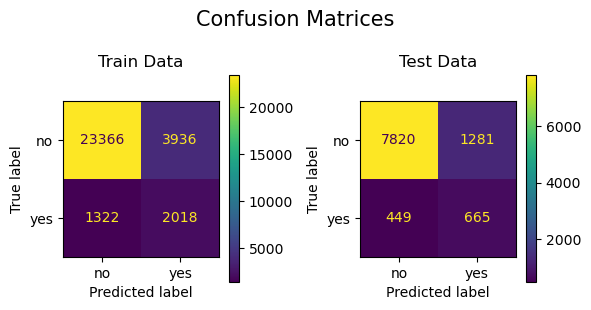

In [86]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, y_train_pred[name]), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_test_pred[name]), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [87]:
# classification report on train data
print(classification_report(y_train, y_train_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.95      0.86      0.90     27302
         yes       0.34      0.60      0.43      3340

    accuracy                           0.83     30642
   macro avg       0.64      0.73      0.67     30642
weighted avg       0.88      0.83      0.85     30642



In [88]:
# classification report on test data
print(classification_report(y_test, y_test_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.95      0.86      0.90      9101
         yes       0.34      0.60      0.43      1114

    accuracy                           0.83     10215
   macro avg       0.64      0.73      0.67     10215
weighted avg       0.88      0.83      0.85     10215



In [89]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].get_feature_names_out()) + \
                list(pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(
    list(pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['imputer'].get_feature_names_out())))

feature_names

['pdays',
 'previous',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_professional.course',
 'education_university.degree',
 'default_unknown',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_nonexistent',
 'poutcome_success']

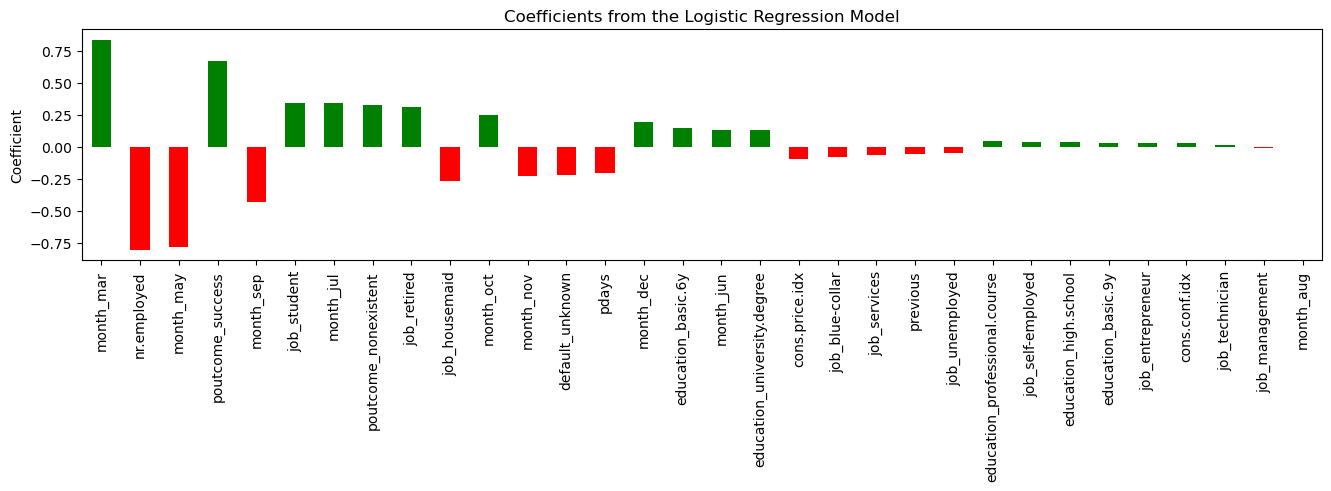

In [90]:
# plot coefficients of the logistic regression model
df_coeff = pd.DataFrame({'columns': feature_names, 
                         'coefficients': pipe.named_steps['log_reg'].coef_.tolist()[0]})

df_coeff.sort_values(by='coefficients',ascending=False, key=abs).plot.bar(x='columns', y='coefficients', legend=False, figsize=(16, 3),
                 color=(df_coeff.sort_values(by='coefficients',ascending=False, key=abs)['coefficients'] > 0).map({True: 'g', False: 'r'}));
plt.xticks(rotation = 90);
plt.ylabel('Coefficient')
plt.title('Coefficients from the Logistic Regression Model')
plt.xlabel('')
plt.show();

The three most important features are:

1. **The month of contact.**
    - Contacting clients in March, July, October, December, or June increases the odds of a success.
    - Contacting clients in May, September, or November decreases the odds of a success.
<br><br>
    
2. **The number of employees.**
    - An increase in the number of employees decreases the odds of a success of a contact.
<br><br>
    
3. **The outcome of the previous marketing campaign.**
    - A successful or nonexistent outcome of the previous marketing campaign increases the odds of a success of a contact.
<br><br>

Further relevant features are:

4. **The type of job.**
    -  Contacting students or retired clients increases the odds of a success.
    -  Contacting housemaids decreases the odds of a success.
<br><br>

5. **Whether the client has credit in default.**
    - An unknown status on whether the client has credit in default decreases the odds of a success of a contact.
<br><br>

6. **The number of days since the last contact from a previous campaign.**
    - An increase in the number of days that pass by after the client was last contacted from a previous campaign decreases the odds of a success of a contact.

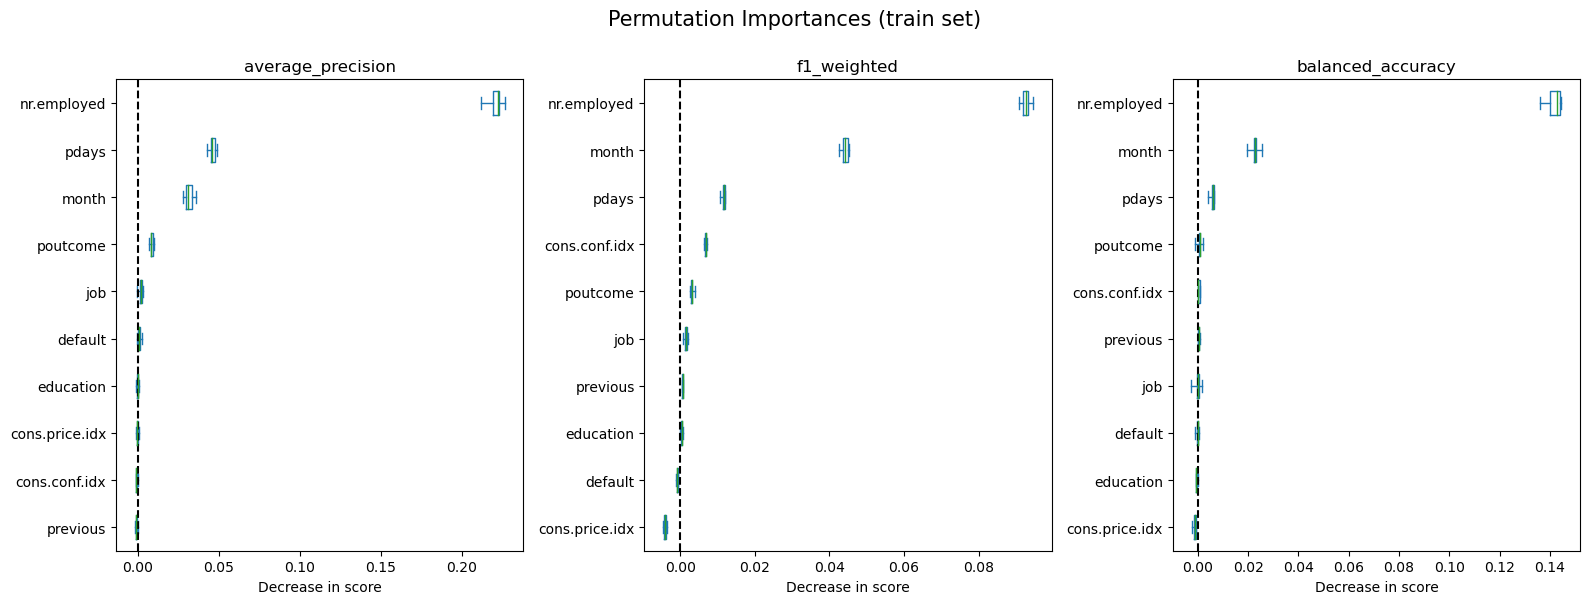

In [92]:
# permutation importances on the training set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_train, y_train, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (train set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_train.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

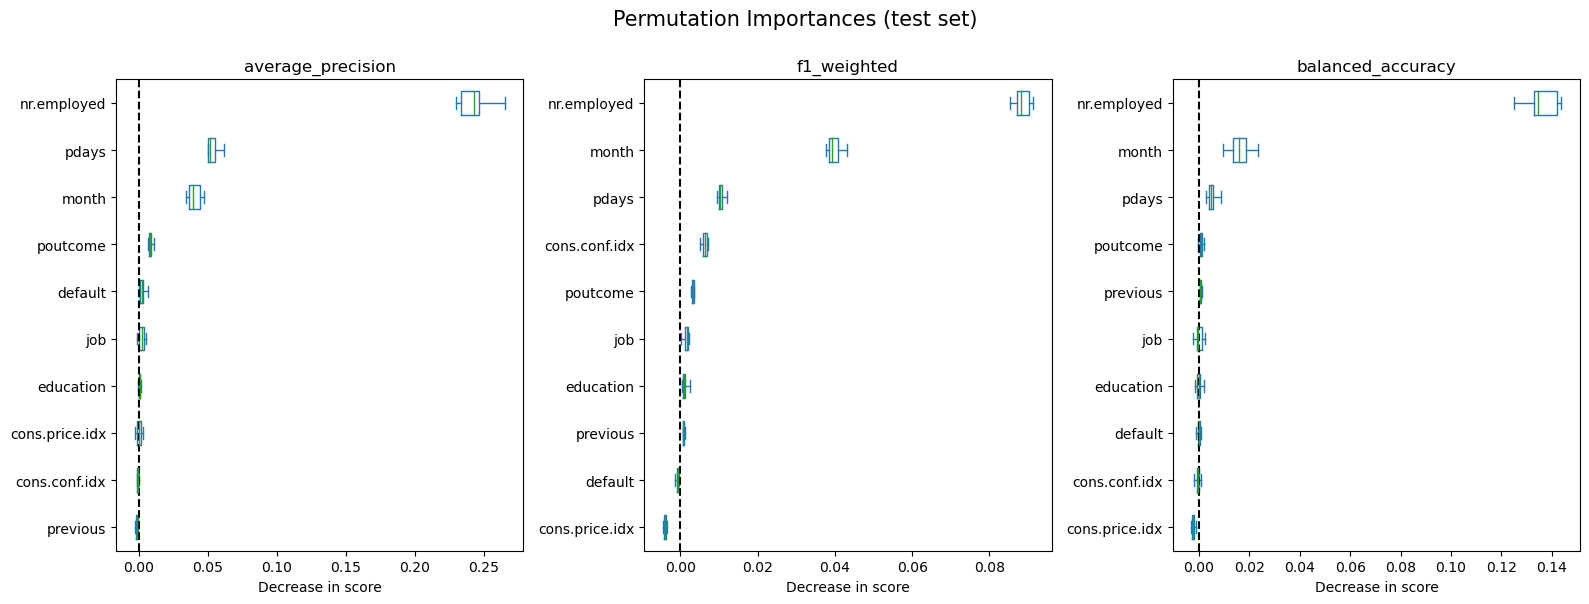

In [93]:
# permutation importances on the test set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (test set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

The permuation importances confirm that the most important features are
- The number of employees.
- The month of contact.
- The number of days since the last contact from a previous campaign.
- The outcome of the previous marketing campaign.

Using the weighted f1 metric, then the consumer confidence index also belongs to the four most important features. As mentioned [here](https://scikit-learn.org/stable/modules/permutation_importance.html), "different metrics might lead to significantly different feature importances, in particular for models trained for imbalanced classification problems, for which the choice of the classification metric can be critical".

##### KNN with Pipeline Preprocessor 1

In [94]:
name = 'KNN'

In [95]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Target encoded and imputed via the IterativeImputer.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', TargetEncoder(handle_unknown='return_nan', handle_missing='return_nan')),
        ('imputer', IterativeImputer(initial_strategy='median', random_state=0))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

In [96]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier(n_jobs=-1, metric='manhattan', n_neighbors=95, p=2, weights='uniform'))
    ]
)
              
# measure CPU time of the fitting process
start_time_ns = time.process_time_ns()
pipe.fit(X_train, y_train)
end_time_ns = time.process_time_ns()

In [97]:
# predict
y_train_pred[name] = pipe.predict(X_train)
y_test_pred[name] = pipe.predict(X_test)

# convert fit time into seconds
train_time[name] = (end_time_ns - start_time_ns)/1e+9

# collect scores
train_avg_precision[name] = average_precision_score(y_train, pipe.predict_proba(X_train)[:, 1])
test_avg_precision[name] = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
train_accuracy[name] = accuracy_score(y_train, y_train_pred[name])
test_accuracy[name] = accuracy_score(y_test, y_test_pred[name])

# difference between train and test scores
diff_avg_precision[name] = train_avg_precision[name] - test_avg_precision[name]
diff_accuracy[name] = train_accuracy[name] - test_accuracy[name]

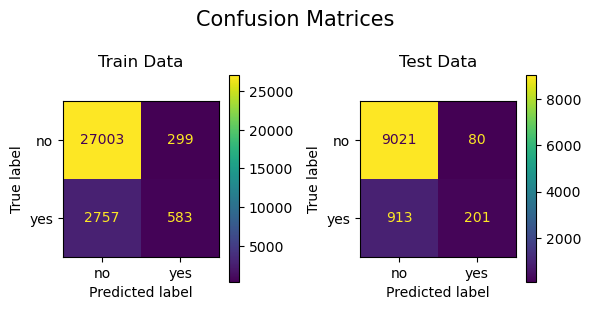

In [98]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, y_train_pred[name]), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_test_pred[name]), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [99]:
# classification report on train data
print(classification_report(y_train, y_train_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.91      0.99      0.95     27302
         yes       0.66      0.17      0.28      3340

    accuracy                           0.90     30642
   macro avg       0.78      0.58      0.61     30642
weighted avg       0.88      0.90      0.87     30642



In [100]:
# classification report on test data
print(classification_report(y_test, y_test_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.91      0.99      0.95      9101
         yes       0.72      0.18      0.29      1114

    accuracy                           0.90     10215
   macro avg       0.81      0.59      0.62     10215
weighted avg       0.89      0.90      0.88     10215



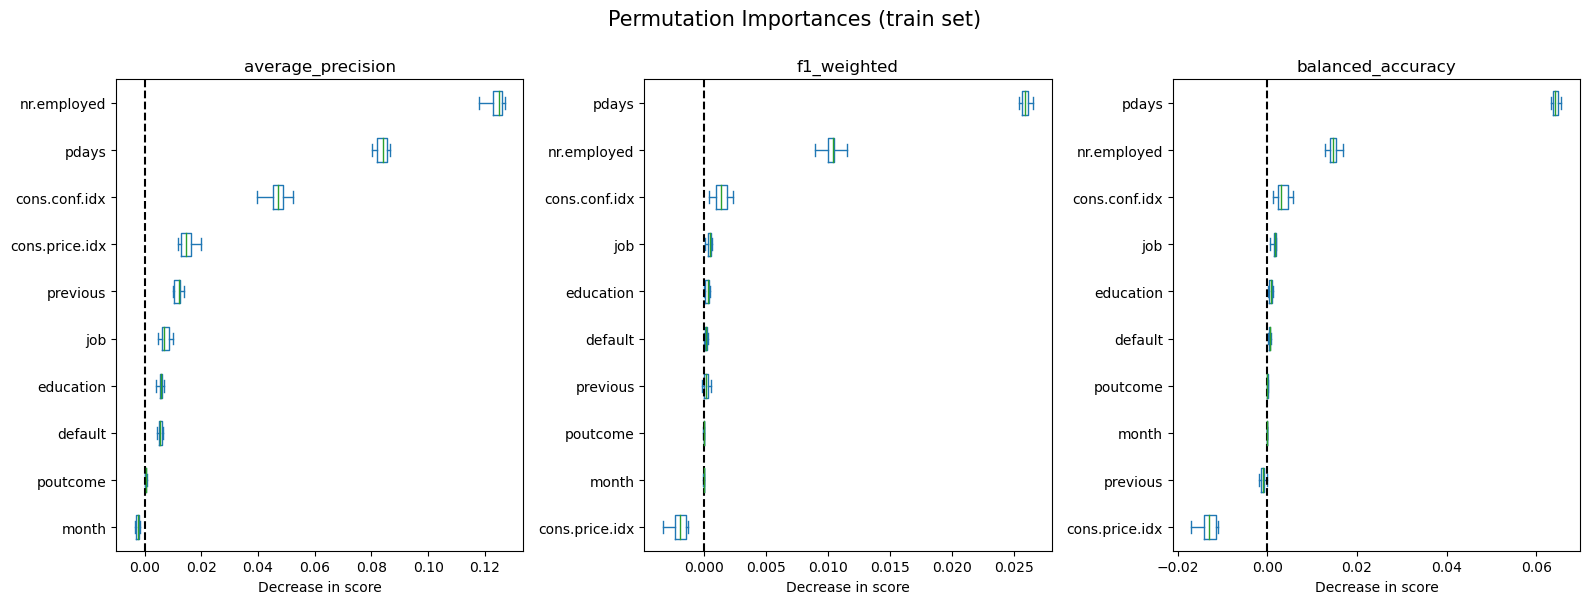

In [101]:
# permutation importances on the training set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_train, y_train, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (train set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_train.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

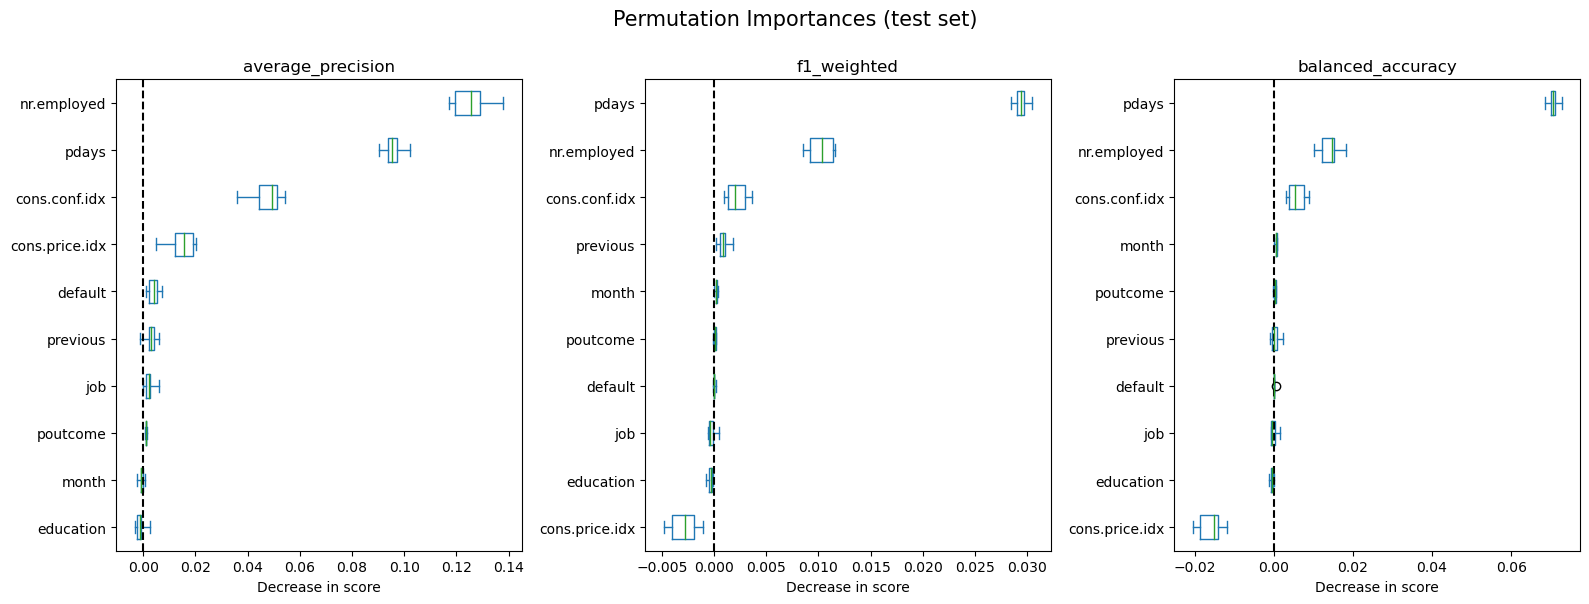

In [102]:
# permutation importances on the test set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (test set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

The most important features are
- The number of days since the last contact from a previous campaign.
- The number of employees.
- The consumer confidence index.

Using the average precision metric, then the consumer price index also belongs to the four most important features.

Interestingly, the most important features are all numeric variables.

##### Decision Tree with Pipeline Preprocessor 1

In [103]:
name = 'Decision Tree'

In [104]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Target encoded and imputed via the IterativeImputer.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', TargetEncoder(handle_unknown='return_nan', handle_missing='return_nan')),
        ('imputer', IterativeImputer(initial_strategy='median', random_state=0))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

In [105]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('tree', DecisionTreeClassifier(random_state=4, class_weight='balanced',
                                        criterion='entropy',
                                        max_depth=11,
                                        max_features='auto',
                                        max_leaf_nodes=99,
                                        min_samples_leaf=100,
                                        min_weight_fraction_leaf=0.0,
                                        splitter='best'))
    ]
)
              
# measure CPU time of the fitting process
start_time_ns = time.process_time_ns()
pipe.fit(X_train, y_train)
end_time_ns = time.process_time_ns()

In [106]:
# predict
y_train_pred[name] = pipe.predict(X_train)
y_test_pred[name] = pipe.predict(X_test)

# convert fit time into seconds
train_time[name] = (end_time_ns - start_time_ns)/1e+9

# collect scores
train_avg_precision[name] = average_precision_score(y_train, pipe.predict_proba(X_train)[:, 1])
test_avg_precision[name] = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
train_accuracy[name] = accuracy_score(y_train, y_train_pred[name])
test_accuracy[name] = accuracy_score(y_test, y_test_pred[name])

# difference between train and test scores
diff_avg_precision[name] = train_avg_precision[name] - test_avg_precision[name]
diff_accuracy[name] = train_accuracy[name] - test_accuracy[name]

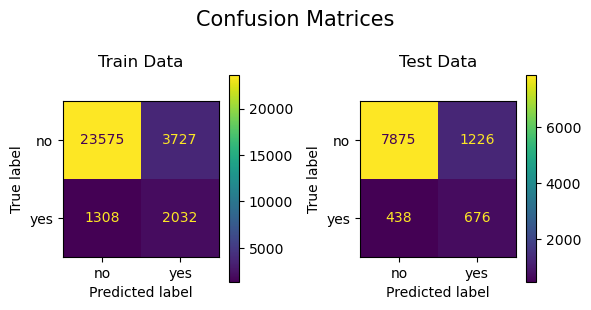

In [107]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, y_train_pred[name]), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_test_pred[name]), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [108]:
# classification report on train data
print(classification_report(y_train, y_train_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.95      0.86      0.90     27302
         yes       0.35      0.61      0.45      3340

    accuracy                           0.84     30642
   macro avg       0.65      0.74      0.68     30642
weighted avg       0.88      0.84      0.85     30642



In [109]:
# classification report on test data
print(classification_report(y_test, y_test_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.95      0.87      0.90      9101
         yes       0.36      0.61      0.45      1114

    accuracy                           0.84     10215
   macro avg       0.65      0.74      0.68     10215
weighted avg       0.88      0.84      0.85     10215



In [110]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].get_feature_names_out()) + \
                pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].cols

feature_names

['pdays',
 'previous',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed',
 'job',
 'education',
 'default',
 'month',
 'poutcome']

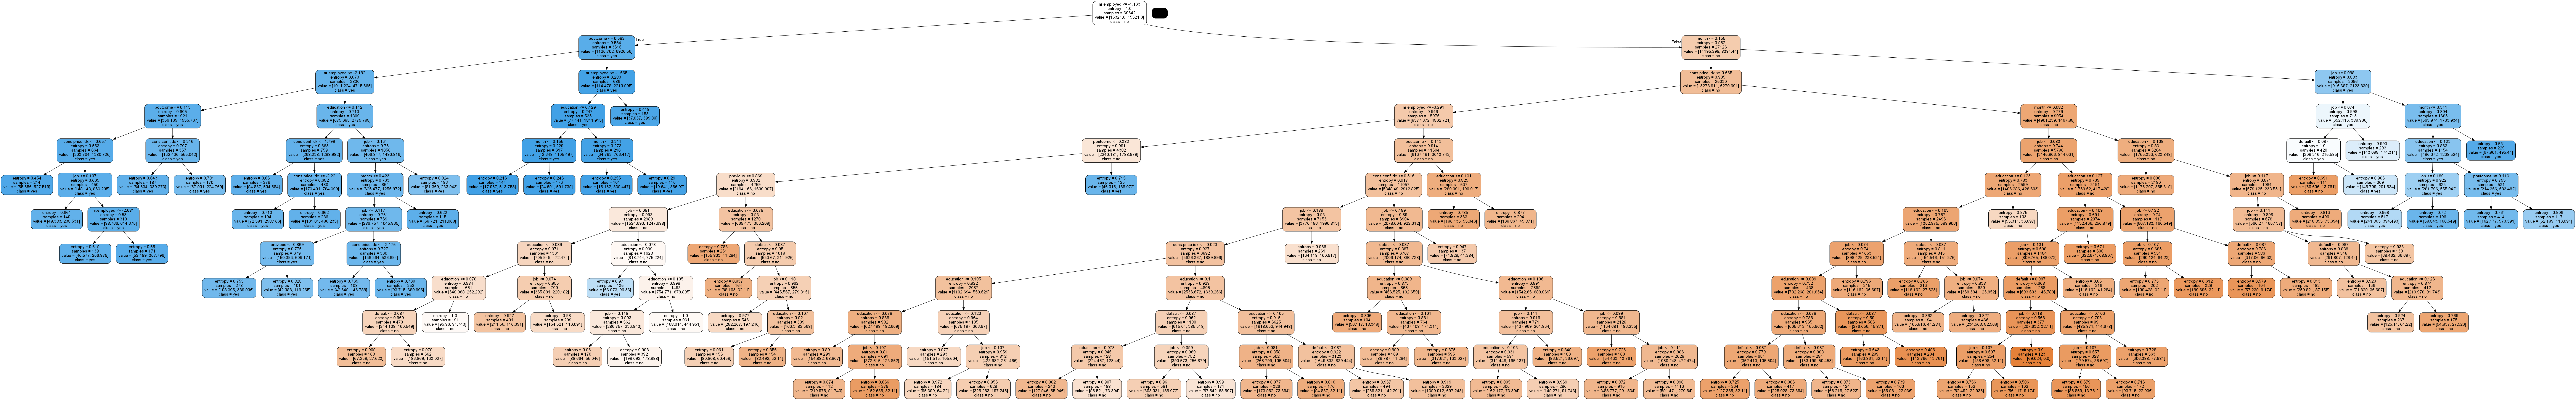

In [111]:
dot_data = StringIO()  

export_graphviz(pipe.named_steps['tree'], out_file=dot_data, filled=True, rounded=True,
                feature_names=feature_names, 
                class_names=['no','yes'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [112]:
graph.write_png('images/tree_model.png')

True

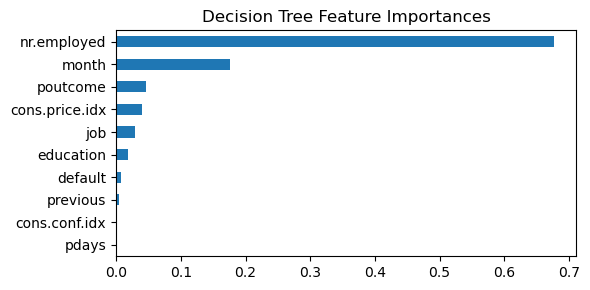

In [113]:
# plot decision tree feature importances
gini_importances = pd.Series(pipe[-1].feature_importances_, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(6,3))
ax = gini_importances.plot.barh()
ax.set_title('Decision Tree Feature Importances')
ax.figure.tight_layout()

The five most important features are:
1. The number of employees.
2. The month of contact.
3. The outcome of the previous marketing campaign.
4. The consumer price index.
5. The type of job.

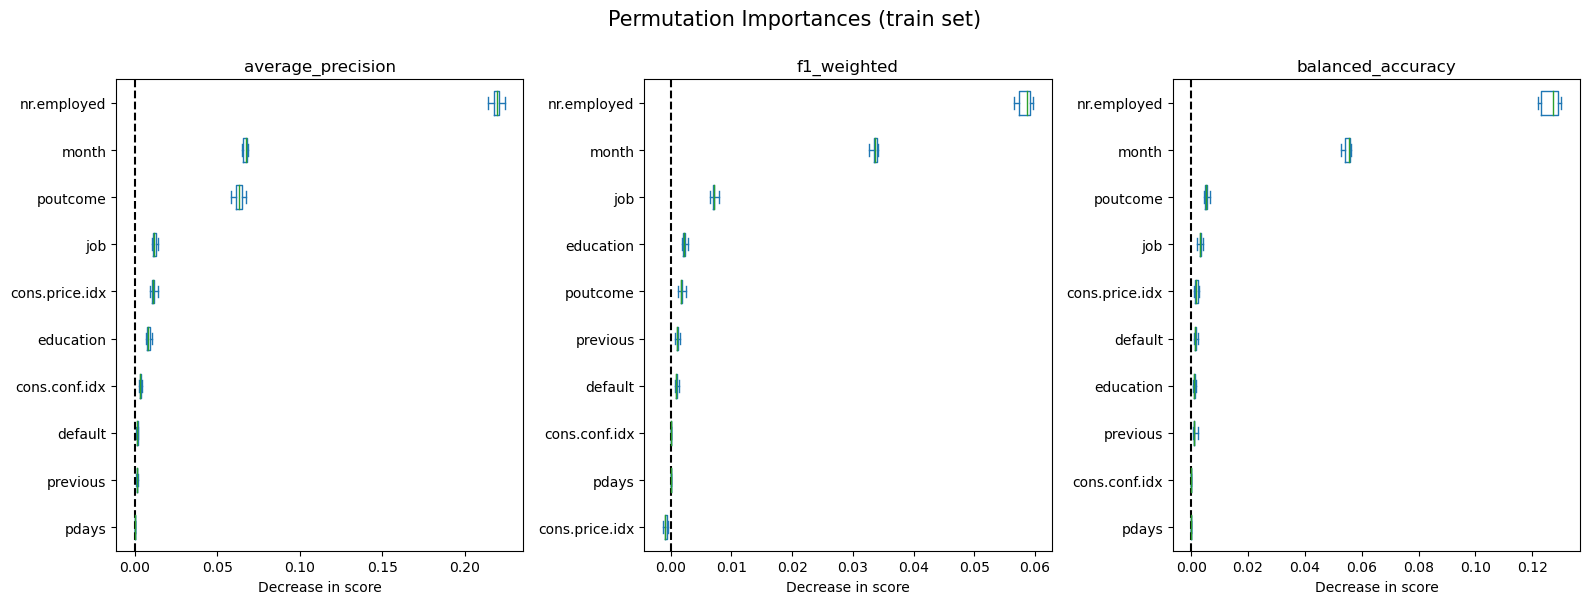

In [114]:
# permutation importances on the training set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_train, y_train, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (train set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_train.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

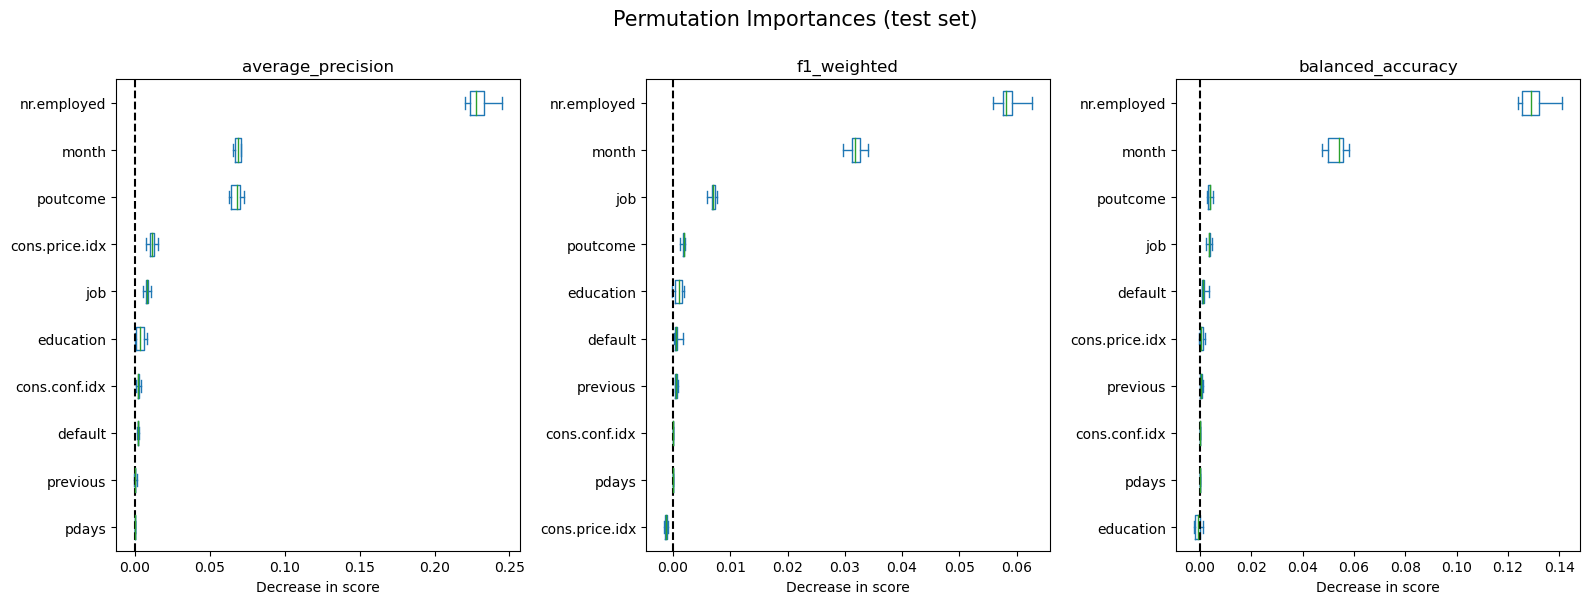

In [115]:
# permutation importances on the test set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (test set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

The permuation importances confirm that the most important features are
- The number of employees.
- The month of contact.
- The outcome of the previous marketing campaign.
- The type of job.

Using the average precision metric, then the consumer price index also belongs to the four most important features.

##### SVM with Pipeline Preprocessor 3

Although Pipeline Preprocessor 2 gave the best mean cross-validated average precision score, we decide to use Pipeline Preprocessor 3, which uses a non-default regularization parameter smaller than 1.

In [116]:
name = 'SVM'

In [117]:
# Column transformer for numeric variables: We standardize numerical features.
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

# Column transformer for nominal variables: Imputed via the SimpleImputer and encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
)

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols)
    ]
)

In [118]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('svc', SVC(random_state=4, class_weight='balanced', probability=True,
                    C=0.00278295186801116, gamma='scale', kernel='linear'))
    ]
)          
              
# measure CPU time of the fitting process
start_time_ns = time.process_time_ns()
pipe.fit(X_train, y_train)
end_time_ns = time.process_time_ns()

In [119]:
# predict
y_train_pred[name] = pipe.predict(X_train)
y_test_pred[name] = pipe.predict(X_test)

# convert fit time into seconds
train_time[name] = (end_time_ns - start_time_ns)/1e+9

# collect scores
train_avg_precision[name] = average_precision_score(y_train, pipe.predict_proba(X_train)[:, 1])
test_avg_precision[name] = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
train_accuracy[name] = accuracy_score(y_train, y_train_pred[name])
test_accuracy[name] = accuracy_score(y_test, y_test_pred[name])

# difference between train and test scores
diff_avg_precision[name] = train_avg_precision[name] - test_avg_precision[name]
diff_accuracy[name] = train_accuracy[name] - test_accuracy[name]

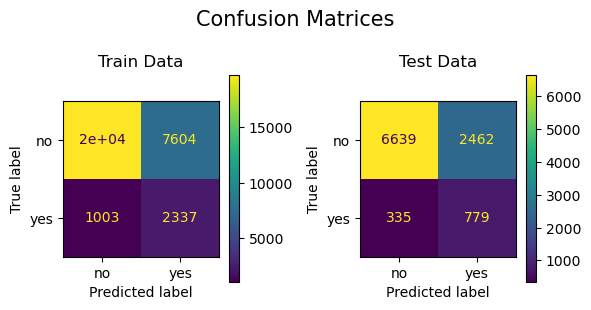

In [120]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, y_train_pred[name]), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_test_pred[name]), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [121]:
# classification report on train data
print(classification_report(y_train, y_train_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.95      0.72      0.82     27302
         yes       0.24      0.70      0.35      3340

    accuracy                           0.72     30642
   macro avg       0.59      0.71      0.59     30642
weighted avg       0.87      0.72      0.77     30642



In [122]:
# classification report on test data
print(classification_report(y_test, y_test_pred[name], target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.95      0.73      0.83      9101
         yes       0.24      0.70      0.36      1114

    accuracy                           0.73     10215
   macro avg       0.60      0.71      0.59     10215
weighted avg       0.87      0.73      0.77     10215



In [123]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].get_feature_names_out()) + \
                list(pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(
    list(pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['imputer'].get_feature_names_out())))

feature_names

['pdays',
 'previous',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_professional.course',
 'education_university.degree',
 'default_unknown',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_nonexistent',
 'poutcome_success']

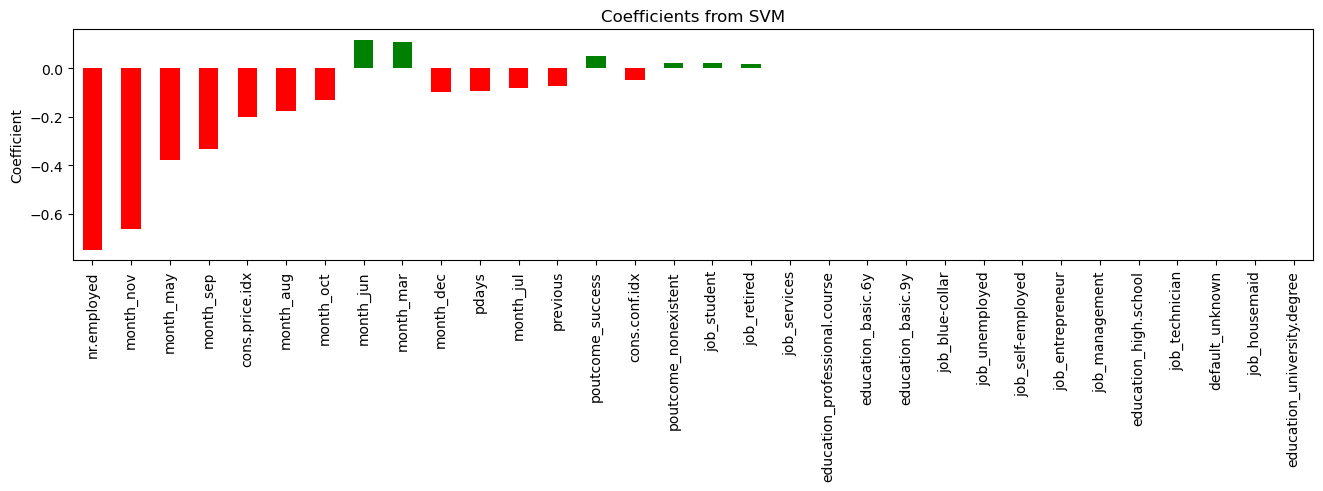

In [124]:
# plot coefficients of SVM
df_coeff = pd.DataFrame({'columns': feature_names, 
                         'coefficients': pipe.named_steps['svc'].coef_.tolist()[0]})

df_coeff.sort_values(by='coefficients',ascending=False, key=abs).plot.bar(x='columns', y='coefficients', legend=False, figsize=(16, 3),
                 color=(df_coeff.sort_values(by='coefficients',ascending=False, key=abs)['coefficients'] > 0).map({True: 'g', False: 'r'}));
plt.xticks(rotation = 90);
plt.ylabel('Coefficient')
plt.title('Coefficients from SVM')
plt.xlabel('')
plt.show();

The three most important features are:
1. **The number of employees.**
    - An increase in the number of employees decreases the odds of a success of a contact.
<br><br>

2. **The month of contact.**
    - Contacting clients in June or March increases the odds of a success.
    - Contacting clients in November, May, September, August, October, December, or July decreases the odds of a success.
<br><br>

3. **The consumer price index.**
    - An increase in the consumer price index decreases the odds of a success of a contact.
    
Further relevant features are:

4. **The number of days since the last contact from a previous campaign.**
    - An increase in the number of days that pass by after the client was last contacted from a previous campaign decreases the odds of a success of a contact.
<br><br>

5. **The number of contacts performed before this campaign and for this client.**
    - An increase in the number of contacts performed before this campaign and for this client decreases the odds of a success of a contact.
<br><br>

6. **The outcome of the previous marketing campaign.**
    - A successful or nonexistent outcome of the previous marketing campaign increases the odds of a success of a contact.
<br><br>

7. **The consumer confidence index.**
    - An increase in the consumer confidence index decreases the odds of a success of a contact.

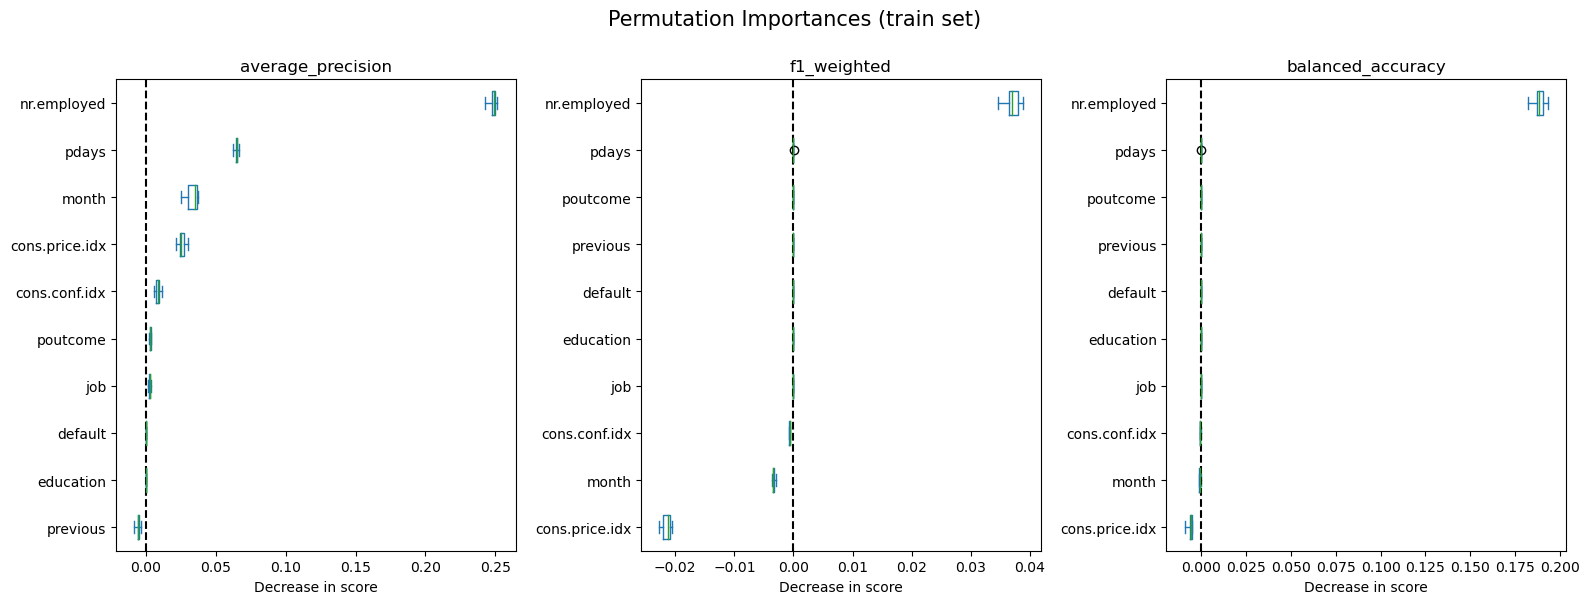

In [126]:
# permutation importances on the training set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_train, y_train, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (train set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_train.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

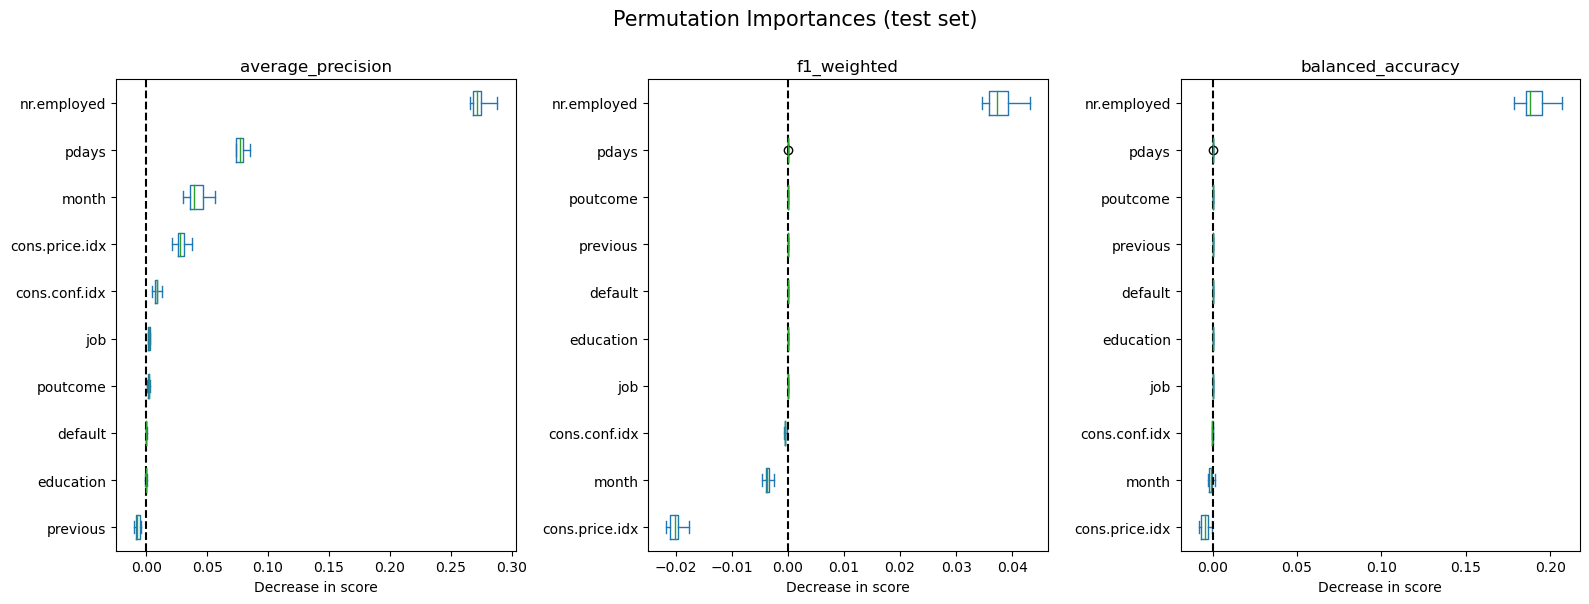

In [127]:
# permutation importances on the test set
scoring = ['average_precision', 'f1_weighted', 'balanced_accuracy']
r_multi = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=0, scoring=scoring)


fig, ax = plt.subplots(1,3, figsize=(16,6))
fig.suptitle('Permutation Importances (test set)', fontsize=15, y=1.)

i=0
for metric in r_multi:
    result = r_multi[metric]
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    g = importances.plot.box(vert=False, whis=10, ax=ax[i])
    g.set_title(metric)
    g.axvline(x=0, color="k", linestyle="--")
    g.set_xlabel("Decrease in score")
    g.figure.tight_layout()
    
    i=i+1

fig.tight_layout()

Using the weighted f1 metric or balanced accuracy metric, then only the number of employees has an impact.

Using the average precision metric, then the permuation importances confirm that the most important features are
- The number of employees.
- The number of days since the last contact from a previous campaign.
- The month of contact.
- The consumer price index.

### Comparison

In [128]:
models_list = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM']

In [129]:
# Take the best mean cross-validated average precision scores from hyperparameter optimization 
# that correspond to our four final models from the previous section.

best_score = {'Logistic Regression': 0.403556165266881,
              'KNN': 0.397020648216011,
              'Decision Tree': 0.399525236446225,
              'SVM': 0.382856992441552,}

In [130]:
# create the dataframe with the model comparisons

results_df = pd.DataFrame({
    'Model' : [name for name in models_list],
    'Best Search Score': [value for _, value in best_score.items()],
    'Train Time' : [value for _, value in train_time.items()],
    'Train Average Precision' : [value for _, value in train_avg_precision.items()],
    'Test Average Precision' : [value for _, value in test_avg_precision.items()],
    'Average Precision Difference' : [value for _, value in diff_avg_precision.items()],
    'Train Accuracy' : [value for _, value in train_accuracy.items()],
    'Test Accuracy' : [value for _, value in test_accuracy.items()]
})
results_df.set_index('Model', inplace=True)

results_df

Best Search Score  Train Time  Train Average Precision  \
Model                                                                         
Logistic Regression           0.403556    0.562500                 0.407271   
KNN                           0.397021    0.437500                 0.417766   
Decision Tree                 0.399525    0.390625                 0.417433   
SVM                           0.382857  305.515625                 0.389366   

                     Test Average Precision  Average Precision Difference  \
Model                                                                       
Logistic Regression                0.434235                     -0.026964   
KNN                                0.427564                     -0.009798   
Decision Tree                      0.429257                     -0.011824   
SVM                                0.413926                     -0.024560   

                     Train Accuracy  Test Accuracy  
Model                                               
Logistic Regression        0.828405       0.830641  
KNN                        0.900268       0.902790  
Decision Tree              0.835683       0.837102  
SVM                        0.719111       0.726187

The best search scores, which are the mean cross-validated average precision scores, lie between 0.38 and 0.41 for all four models.

KNN is the best model in terms of train average precision score, closely followed by the decision tree. KNN also has
- the lowest difference between the train and test average precision score, and
- by far the best train and test accuracy of 0.9.

Logistic Regression is the best model in terms of test average precision score, which is even higher than its train average precision score.

SVM performs the worst in terms all of above metrics among the four models.

In this regard, KNN is the best model.

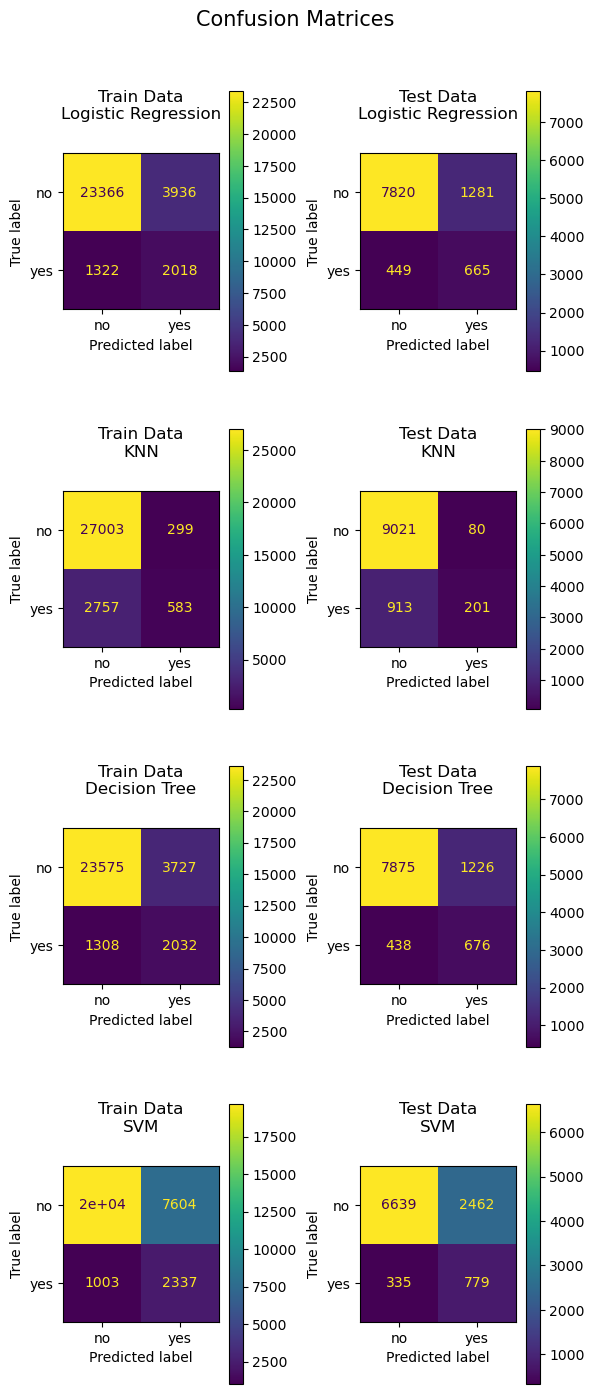

In [131]:
# confusion matrices

fig, ax = plt.subplots(4, 2, figsize=(6,14))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

i=0
n_cols=2
# loop over the four models
for name in models_list:

    # confusion matrix on train data
    cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, y_train_pred[name]), 
                                              display_labels = np.array(['no','yes']))
    cm_display_train.plot(ax=ax[i//n_cols,i%n_cols])
    ax[i//n_cols,i%n_cols].set_title('Train Data\n{}'.format(name), pad=25)

    # confusion matrix on test data
    cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_test_pred[name]), 
                                             display_labels = np.array(['no','yes']))
    
    cm_display_test.plot(ax=ax[(i+1)//n_cols,(i+1)%n_cols])
    ax[(i+1)//n_cols,(i+1)%n_cols].set_title('Test Data\n{}'.format(name), pad=25)
    
    i=i+2
    
fig.tight_layout()

In [133]:
# loop over the four models
for name in models_list:
    print(name)
    
    # classification report on train data
    print('  train')
    print(classification_report(y_train, y_train_pred[name], target_names=['no','yes']))

    # classification report on test data
    print('  test')
    print(classification_report(y_test, y_test_pred[name], target_names=['no','yes']))

Logistic Regression
  train
              precision    recall  f1-score   support

          no       0.95      0.86      0.90     27302
         yes       0.34      0.60      0.43      3340

    accuracy                           0.83     30642
   macro avg       0.64      0.73      0.67     30642
weighted avg       0.88      0.83      0.85     30642

  test
              precision    recall  f1-score   support

          no       0.95      0.86      0.90      9101
         yes       0.34      0.60      0.43      1114

    accuracy                           0.83     10215
   macro avg       0.64      0.73      0.67     10215
weighted avg       0.88      0.83      0.85     10215

KNN
  train
              precision    recall  f1-score   support

          no       0.91      0.99      0.95     27302
         yes       0.66      0.17      0.28      3340

    accuracy                           0.90     30642
   macro avg       0.78      0.58      0.61     30642
weighted avg       0.88    

SVM is the best model in terms of recall score (for the `yes`-class), while KNN is the worst under this metric.

The decision tree is the best model in terms of f1 score (for the `yes`-class), while KNN is the worst under this metric.

KNN is the best model in terms of weighted average precision/recall/f1 scores.

### Findings

Clearly stated findings in their own section with actionable items highlighted in appropriate language for a non-technical audience.

Overall, KNN is the best model for accurate predictions, achieving the highest scores among the four models with regard to different metrics:
- average precision score on the train/test set: 41.78% / 42.76%
- accuracy score on the train/test set: 90.03% / 90.28%
- weighted average precision score on the train/test set: 88% / 89%
- weighted average recall score on the train/test set: 90% / 90%
- weighted average f1 score on the train/test set: 87% / 88%
<br><br>

Comparing the feature importance results among the models, the most relevant features are:
- **The number of employees:**
    - The number of employees has a negative effect on turning people to subscribe a deposit.
<br><br>

- **The month of contact:**
    - Contacting clients in March, July, October, December, or June will make them more likely to subscribe a deposit.
    - Contacting clients in May, September, or November will make them less likely to subscribe a deposit.
<br><br>

- **The number of days since the last contact from a previous campaign:**
    - If a lot of time has passed since a client was last contacted from a previous campaign or if a client has never been previously contacted, then the client is less likely to subscribe a deposit.
<br><br>

- **The outcome of the previous marketing campaign:**
    - If a client subscribed via the previous marketing campaign or was not contacted for the previous marketing campaign, then the client is more likely to subscribe a deposit.

### Next Steps and Recommendations

To increase the chance that a client will subscribe a deposit:
- Schedule marketing campaigns in the months of March, July, October, December, and June.
- New clients should be contacted relatively soon.
- Contact clients relatively soon after the last contact with them from a previous campaign.
- Contact clients that subscribed via the previous marketing campaign or were not contacted for the previous marketing campaign.